## Setup Simulation

Import needed libraries and define constants

In [1]:
# Set plotting in separate window
#%matplotlib qt
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft, fftfreq
from matplotlib import pyplot as plt
from pathlib import Path
# Constants
c0 = 1 # um/ps
di = 0.003 # 0.003 um
dn = di/c0 # (0.003 um) / (300 um/ps) = 0.00001 ps = 0.01 fs
epsilon0 = 1
mu0 = 1

Define simulation bounds and calculate length in indicies

In [2]:
# Define bounds
i0 = -5 # -5 um
i1 = 5 # 5 um
n0 = -90 # (0.01 fs) * (-90 um) / (0.003 um/step) = (0.01 fs) * (-30,000 steps) = -300 fs
n1 = 210 # (0.01 fs) * (210 um) / (0.003 um/step) = (0.01 fs) * (70,000 steps) = 700 fs
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)

In [3]:
print(nlen, ilen)

100000 3335


Create our time and space arrays to help construct our material and current pulse

In [4]:
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False) * (10/3) # Multiply by 10/3 to get from um -> fs
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)

## Setup Material

Specify the location of our material (which will be $0.09$um in length)

In [5]:
# Set material length
m_len = 0.09 # 0.09 um
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [6]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [7]:
# Set constants
a = np.complex64(1)
gamma = np.complex64(0.01)
freq = np.complex64(1)
# Calculate beta
ang_gamma = np.complex64(gamma * 2 * np.pi)
omega = np.complex64(freq * 2 * np.pi)
beta = np.sqrt(np.add(np.square(ang_gamma), -np.square(omega)), dtype=np.complex64)
a1 = np.complex64(a/(2*beta))
a2 = np.complex64(-a/(2*beta))

In [8]:
print(gamma, beta, a1, a2)

(0.01+0j) 6.2828712j -0.07958145j (-0+0.07958145j)


Create our material behavior matrices

In [9]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * ang_gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [10]:
inf_perm = 16
material = Mat(dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, storelocs=[1])

## Specifying Currents

Specify the location of our current pulses in time and space

In [11]:
cp_loc_val = -3 # -3 um
cp_time_val = 0 # 0 fs

Determine the simulation indicies that correspond to these locations

In [12]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = int(250 / 0.01) # (250 fs) / (0.01 fs/step) = 25,000 steps
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread

Make a list to hold our current pulses

In [13]:
cpulse_list_names = ['gauss', 'd_gauss', 'dd_gauss', 'ddd_gauss', 'dddd_gauss', 'loren', 'd_loren', 'dd_loren']
cpulse_list = []

Create the Gaussian current pulse

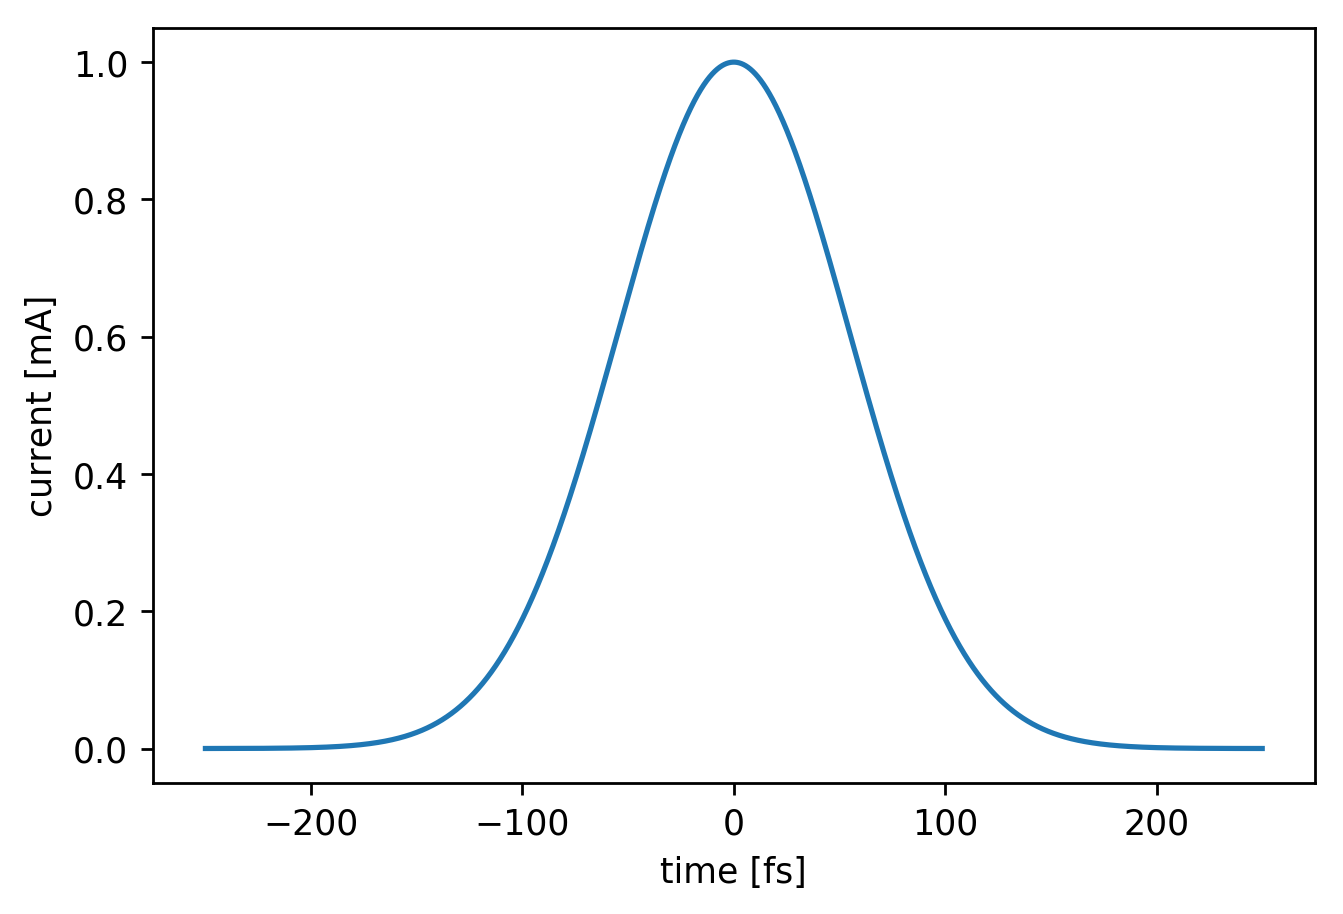

In [14]:
# Make pulse
cpulse = np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3))
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the first derivative of the Gaussian current pulse

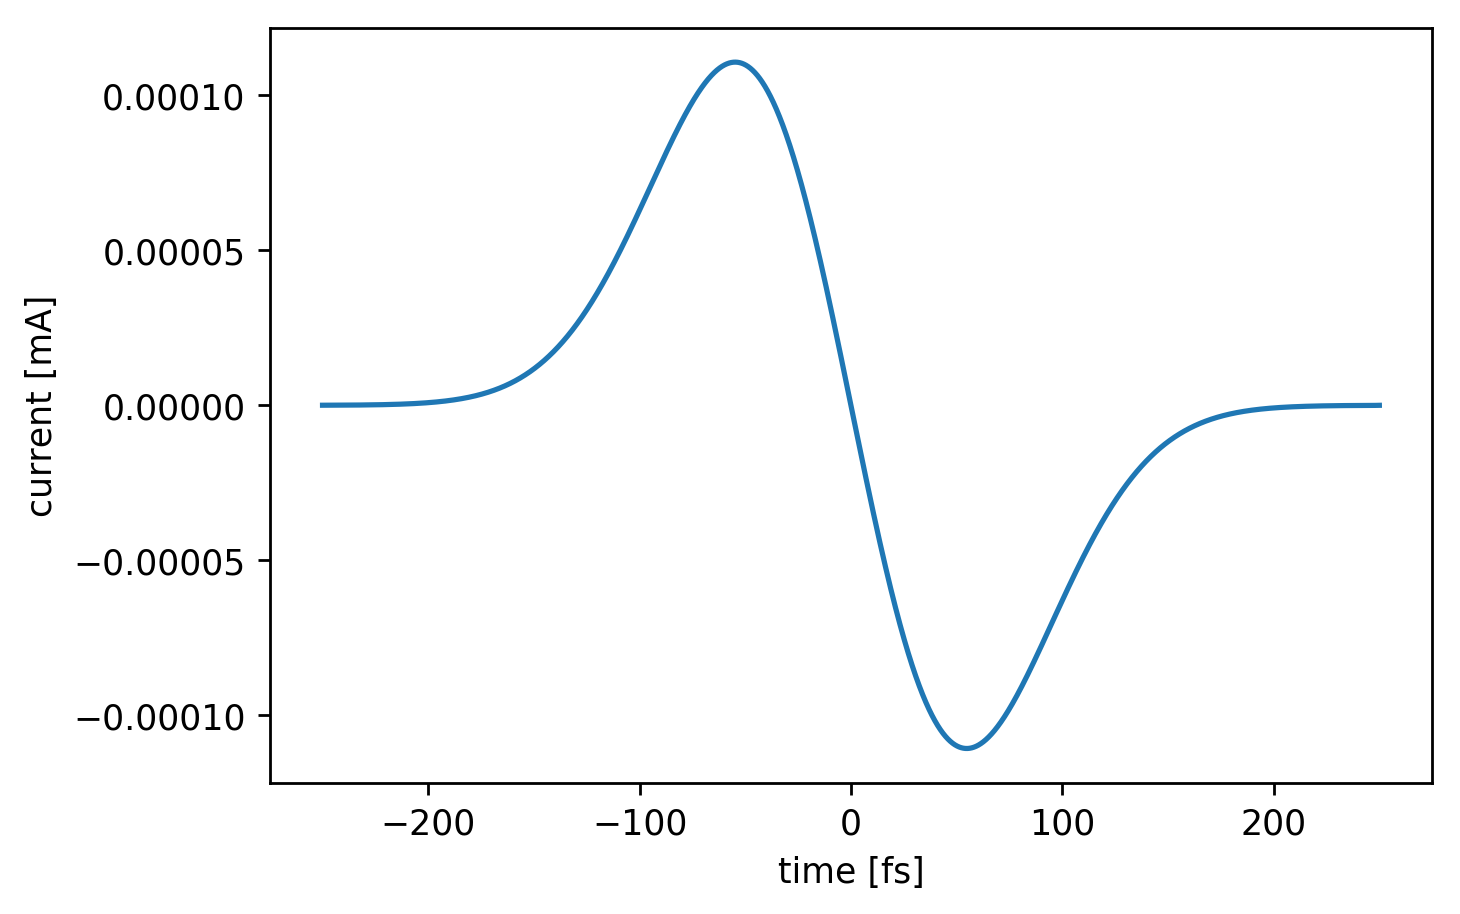

In [15]:
# Make pulse
cpulse = np.append(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3))), [0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the second derivative of the Gaussian current pulse

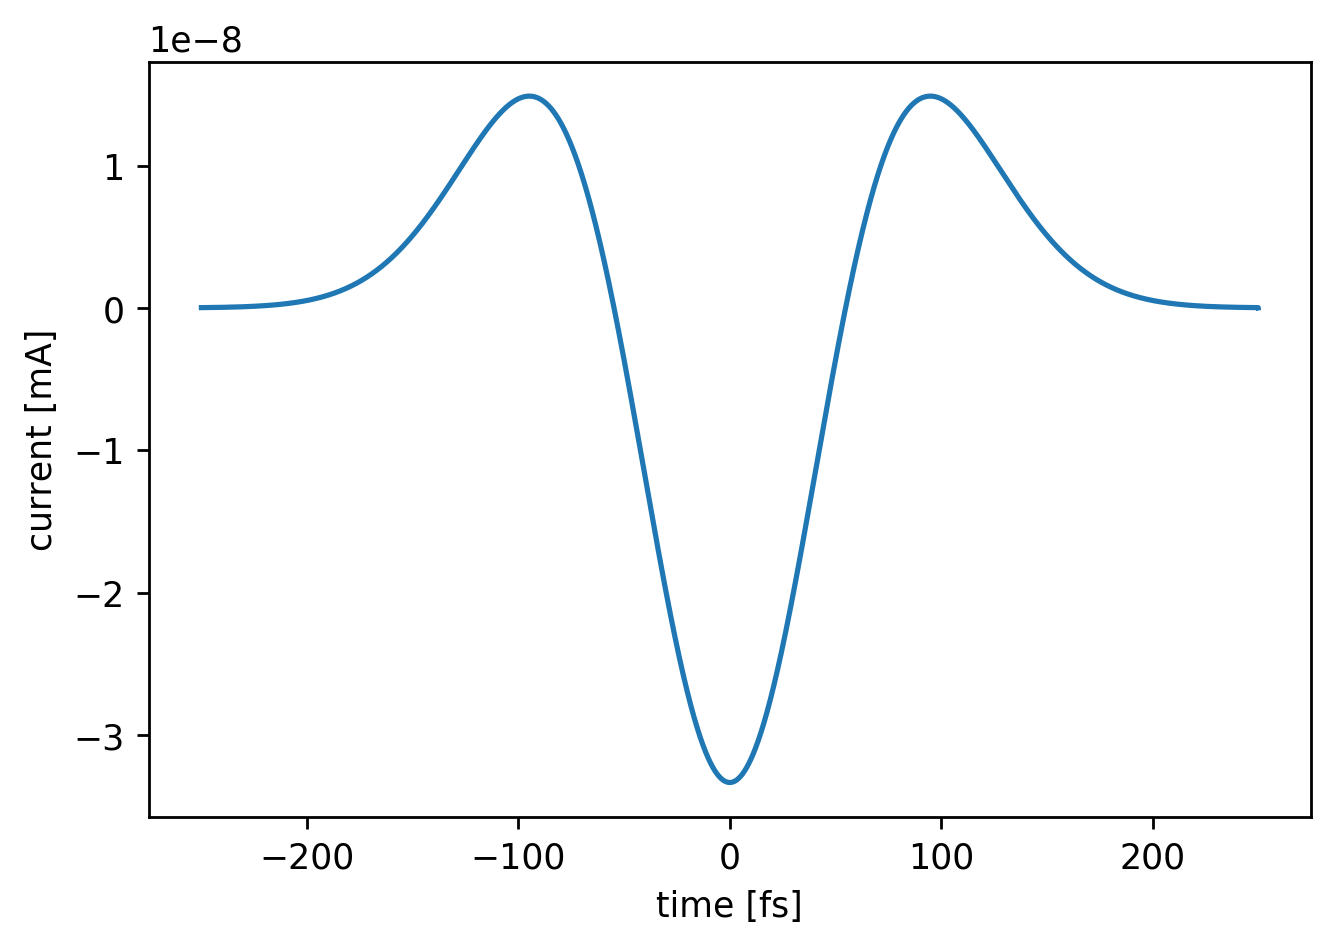

In [16]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3)))), [0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the third derivative of the Gaussian current pulse

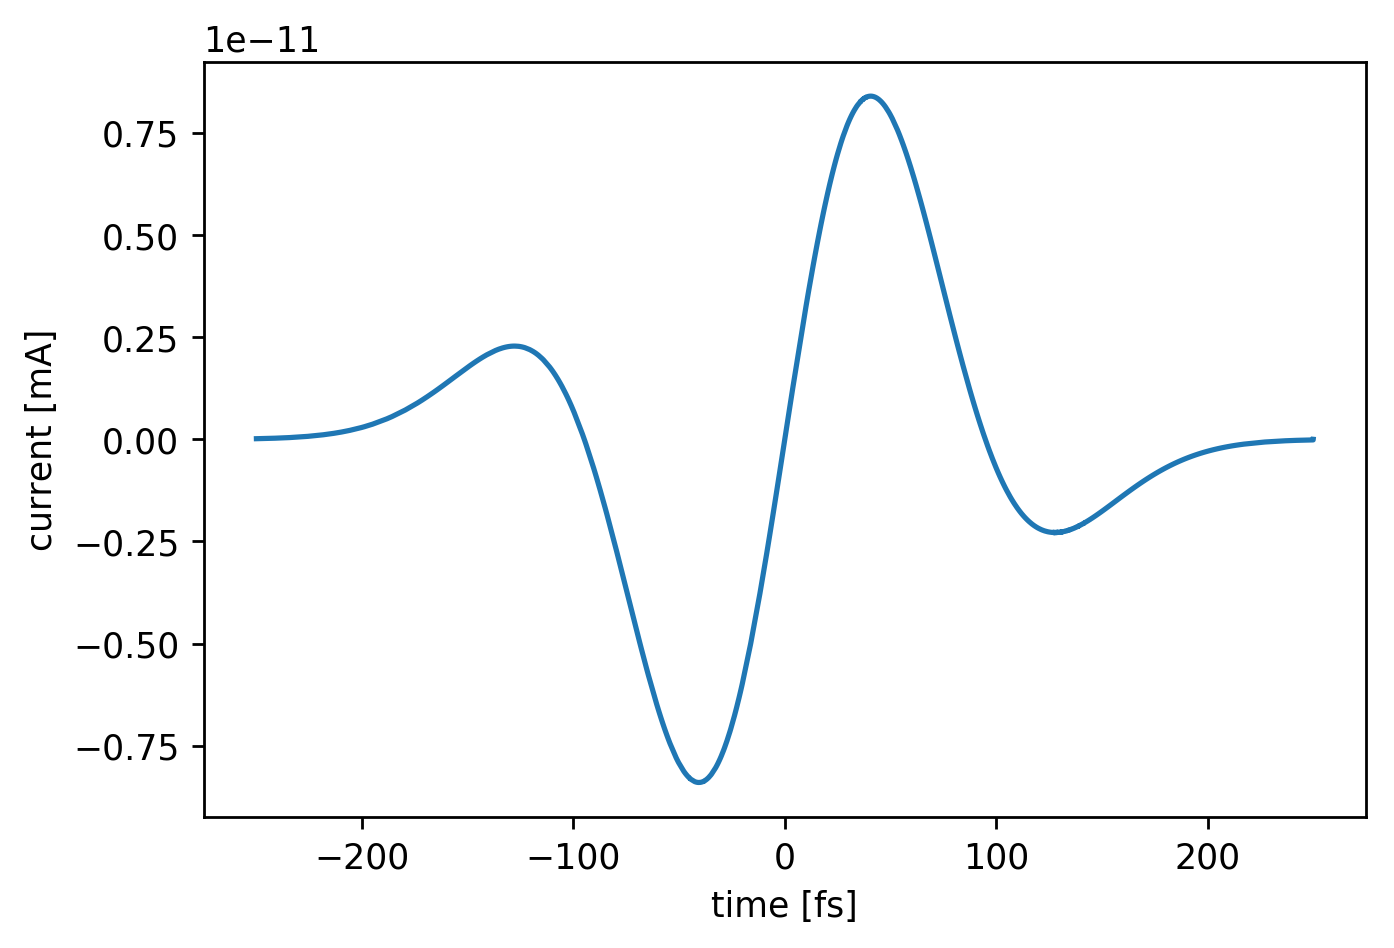

In [17]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3))))), [0,0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the fourth derivative of the Gaussian current pulse

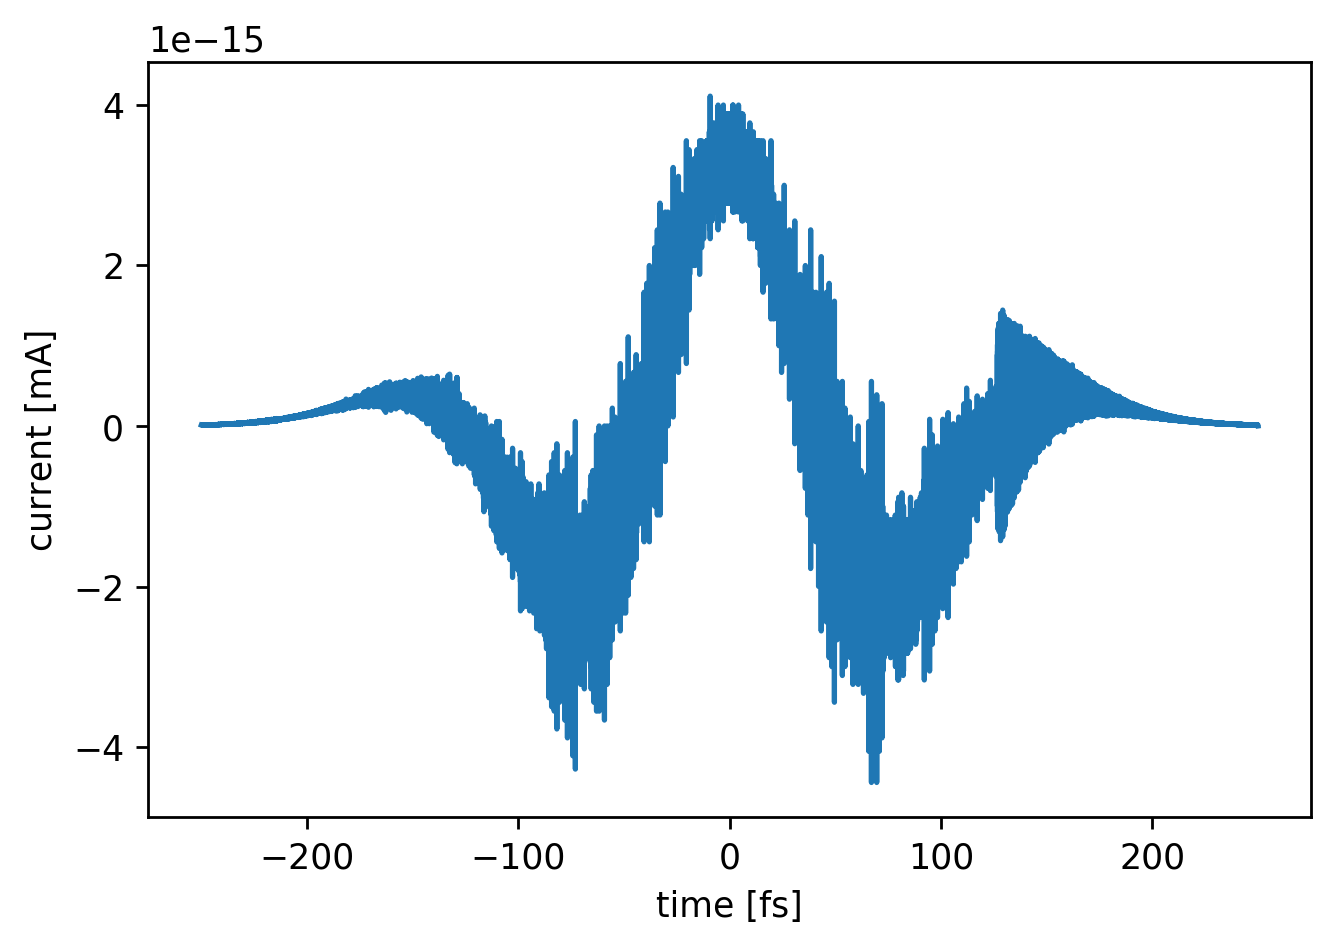

In [18]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3)))))), [0,0,0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the Lorentzian current pulse

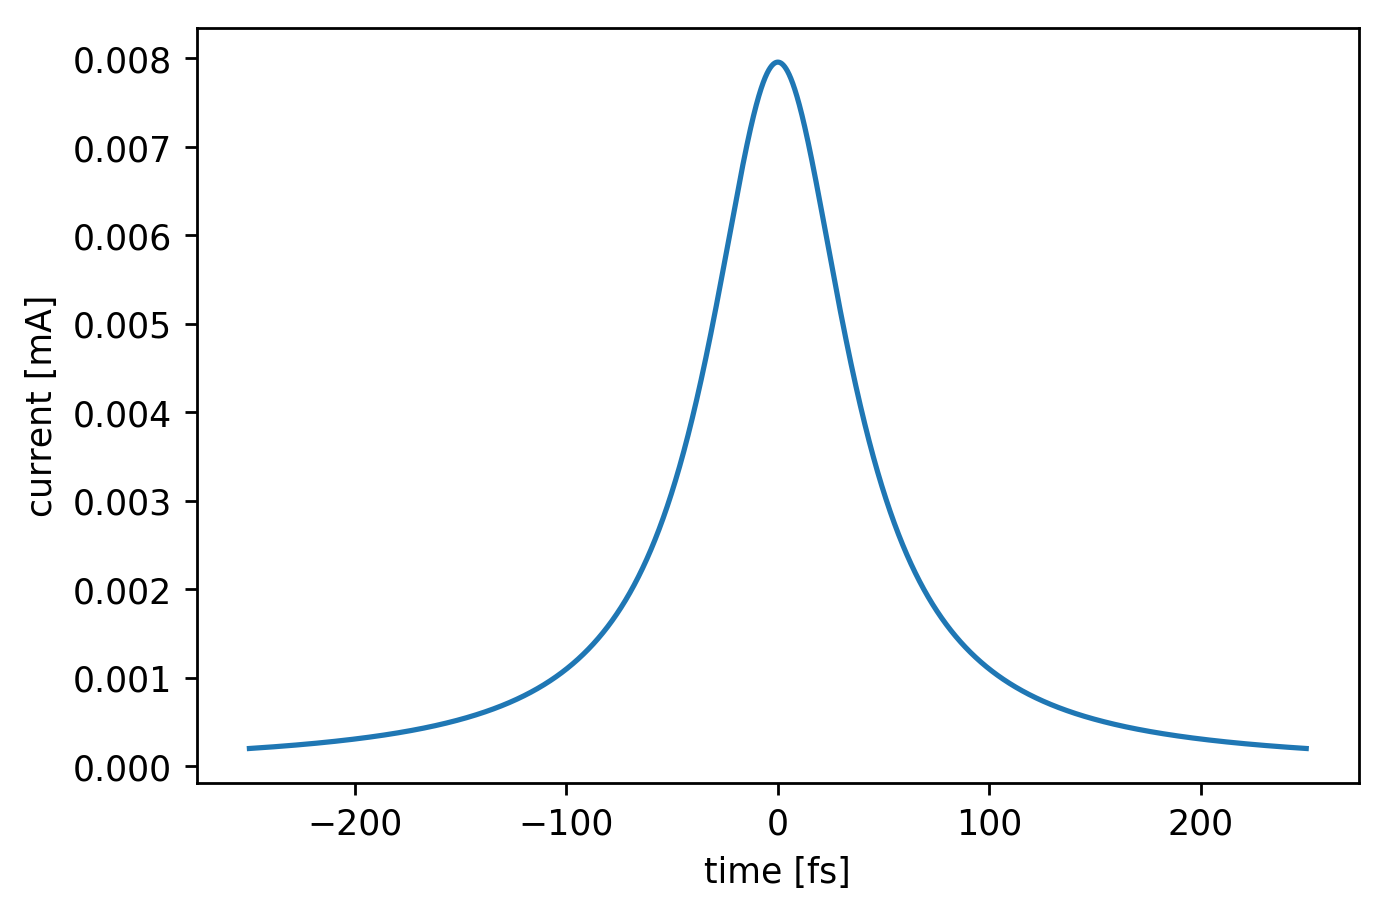

In [19]:
# Make pulse
Gamma = 80
cpulse = np.divide(0.5*Gamma, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*Gamma)))
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the first derivative of the Lorentzian current pulse

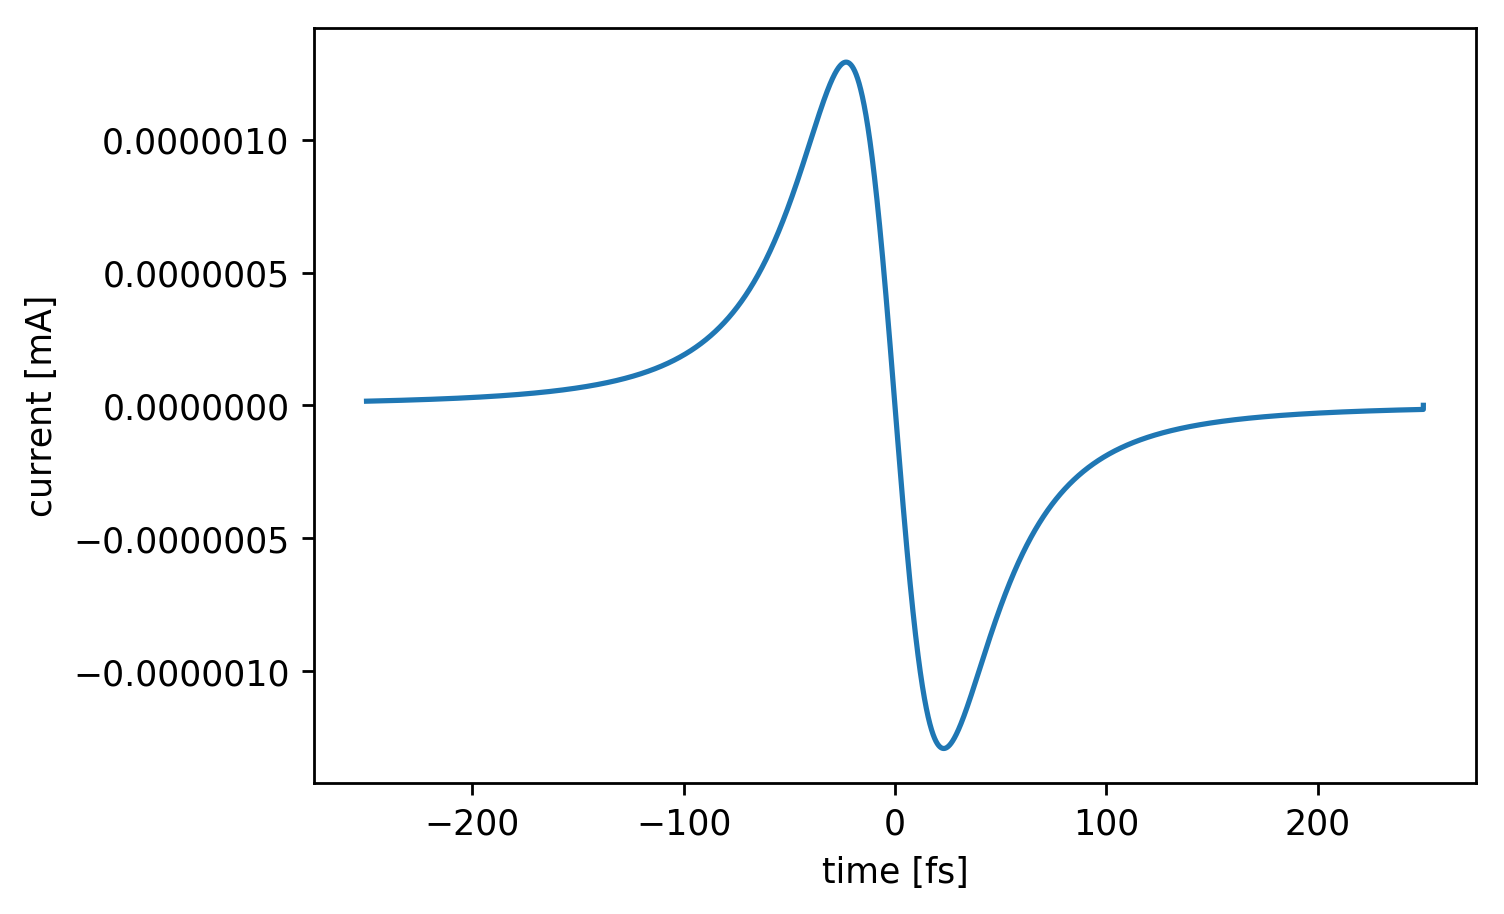

In [20]:
# Make pulse
Gamma = 80
cpulse = np.append(np.diff(np.divide(0.5*Gamma, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*Gamma)))), [0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

Create the second derivative of the Lorentzian current pulse

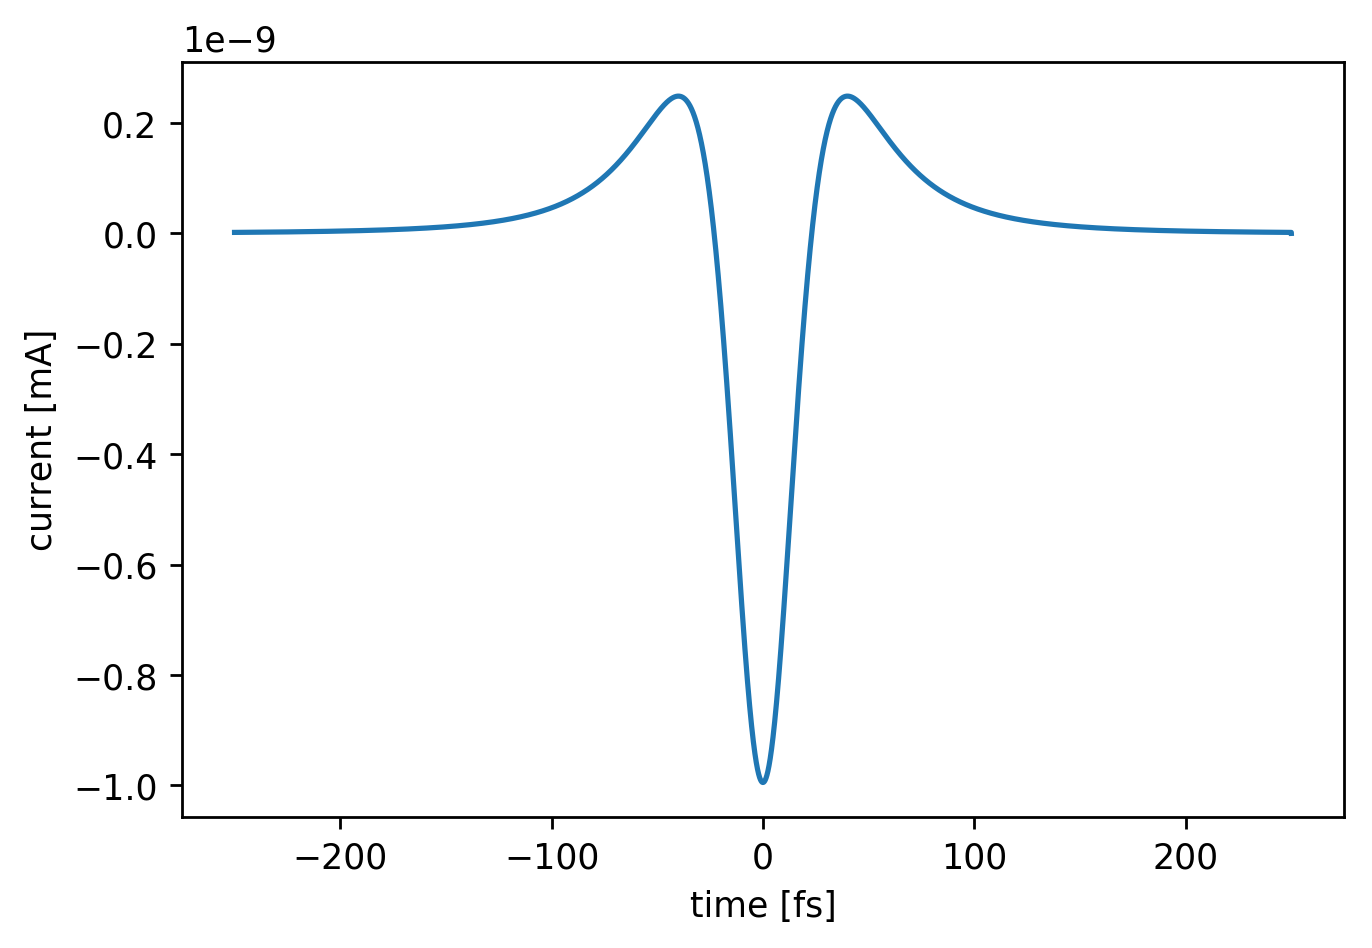

In [21]:
# Make pulse
Gamma = 80
cpulse = np.append(np.diff(np.diff(np.divide(0.5*Gamma, np.pi*np.add(np.square(t[cp_time_s:cp_time_e] - cp_time_val), np.square(0.5*Gamma))))), [0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.gcf().set_dpi(250)
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)
# Add to list
cpulse_list.append(current)

## Running the Simulations

Create and run a simulation for each current (or load simulation result if one already exists)

In [22]:
# Loop through all currents
for i in range(len(cpulse_list)):
    # Extract name info and current pulse
    sfname = cpulse_list_names[i] + '.npz'
    tfname = cpulse_list_names[i] + '.mp4'
    cpulse = cpulse_list[i]
    # Only proceed if simulation doesn't exist
    sim_file = Path(sfname)
    if not sim_file.is_file():
        # Create simulation object
        s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', cpulse, material, nstore=int(nlen/80), storelocs=[5,ilen-6])
        # Run simulation
        s.simulate()
        # Save results
        n, ls, els, erls, hls, hrls = s.export_locs()
        ls_mat, chi = material.export_locs()
        n = n * (10/3) # 10/3 scale factor converts from um -> fs
        np.savez(sfname, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)
        # Save timeseries
        print('Saving ' + tfname + '... patience, this can take a while!')
        vis.timeseries(s, iunit='um', fname=tfname)

## Displaying simulation results

We create a function to calculate $E_i(t)$, $E_t(t)$, and $E_r(t)$.

In [23]:
def calc_fields(els, erls):
    # Extract the reference E-field passing through i=ilen-6 as the incident field
    inc = erls[:,1]
    # Extract the E-field passing through i=ilen-6 as the transmitted field
    trans = els[:,1]
    # Extract the E-field passing through i=5 and the reference E-field passing through i=5 to calculate the reflected field
    r = els[:,0] # Extract the transmitted E-field
    rref = erls[:,0]
    refl = r - rref
    # Return inc, trans, refl
    return (inc, trans, refl)

Create a function to calculate the $E_i(\omega)$, $E_t(\omega)$, and $E_r(\omega)$, that is the Fourier transforms of $E_i(t)$, $E_t(t)$, and $E_r(t)$.

In [24]:
def calc_transforms(nlen, dn, inc, trans, refl):
    # Determine the frequency axis
    nf = fftfreq(nlen, dn) * 1e4 #  # Mulitply by 1e4 to go from units of 1e16 Hz -> 1e14 Hz which is THz
    # Perform FFT on each field
    incf = fft(inc)
    transf = fft(trans)
    reflf = fft(refl)
    # Discard negative frequencies (at nlen/2 and above) and keep DC (at 0) for each field
    nf = nf[0:int(nlen/2)]
    incf = incf[0:int(nlen/2)]
    transf = transf[0:int(nlen/2)]
    reflf = reflf[0:int(nlen/2)]
    # Return nf, incf, transf, and reflf
    return (nf, incf, transf, reflf)

Generate plots for each current simulation

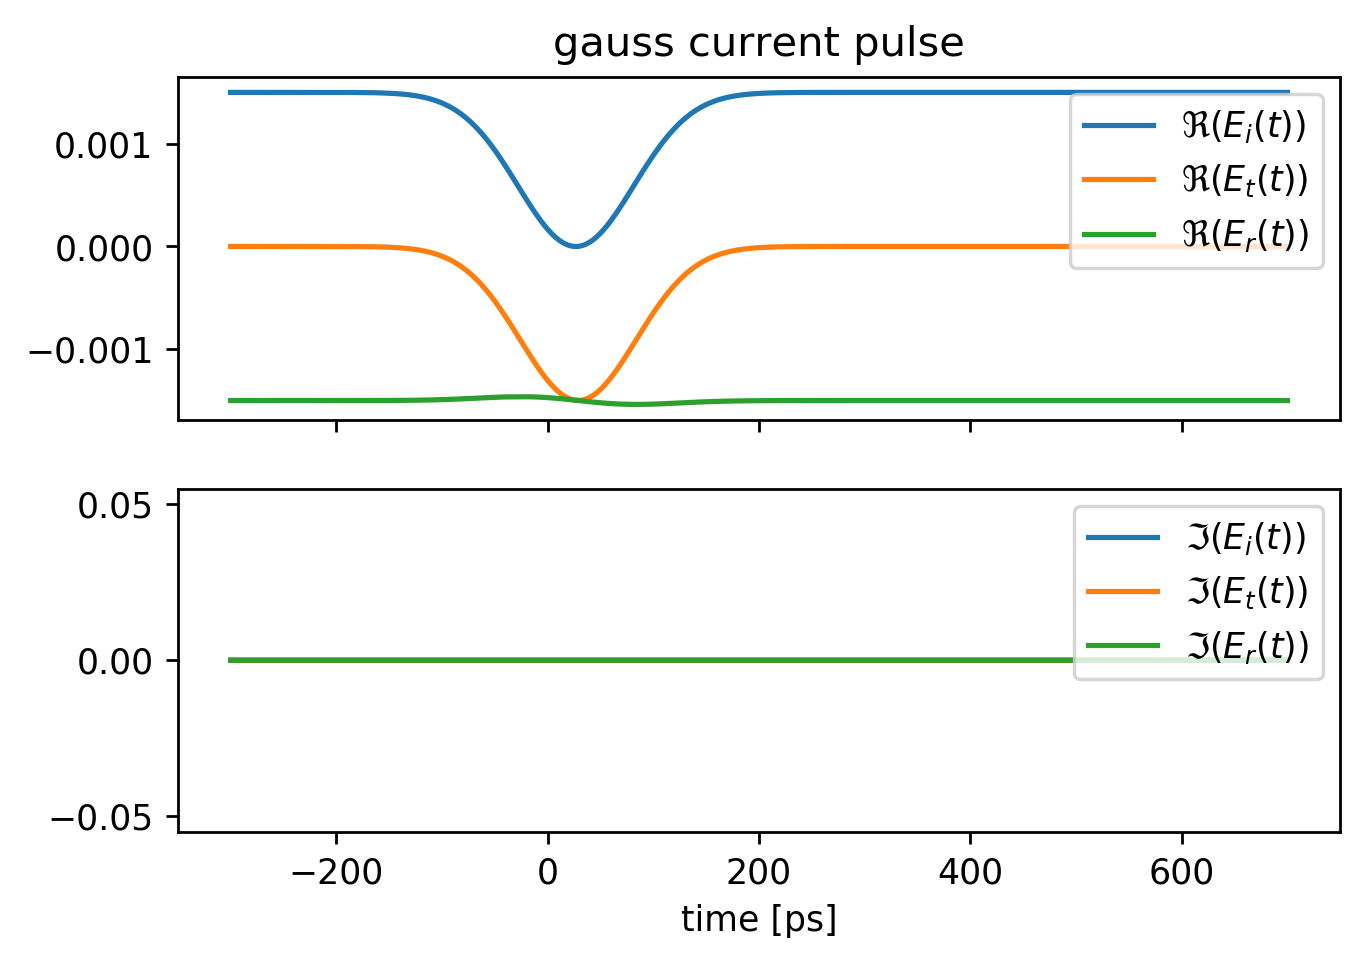

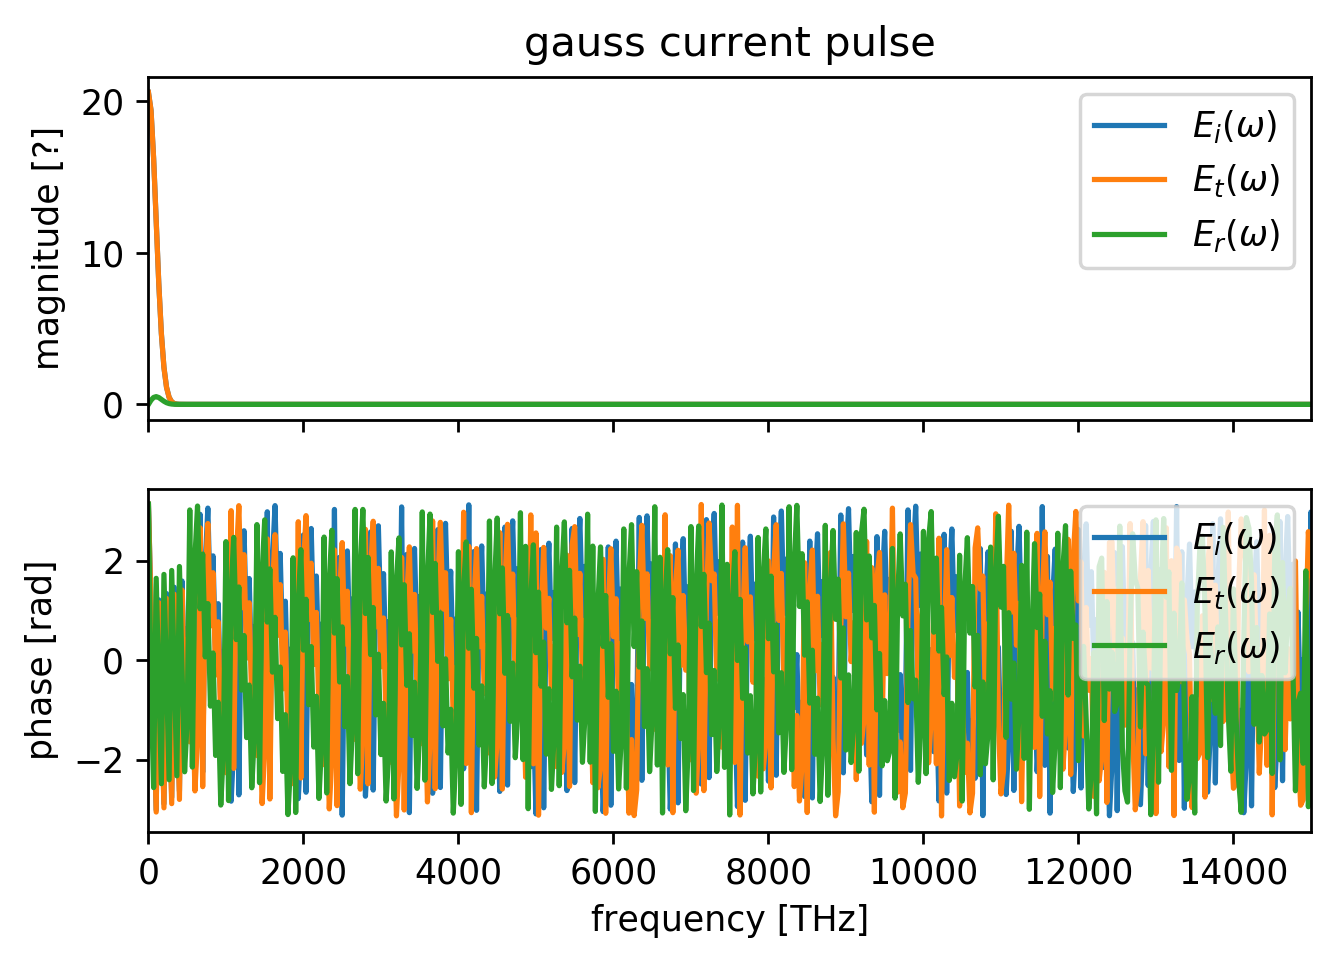

/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


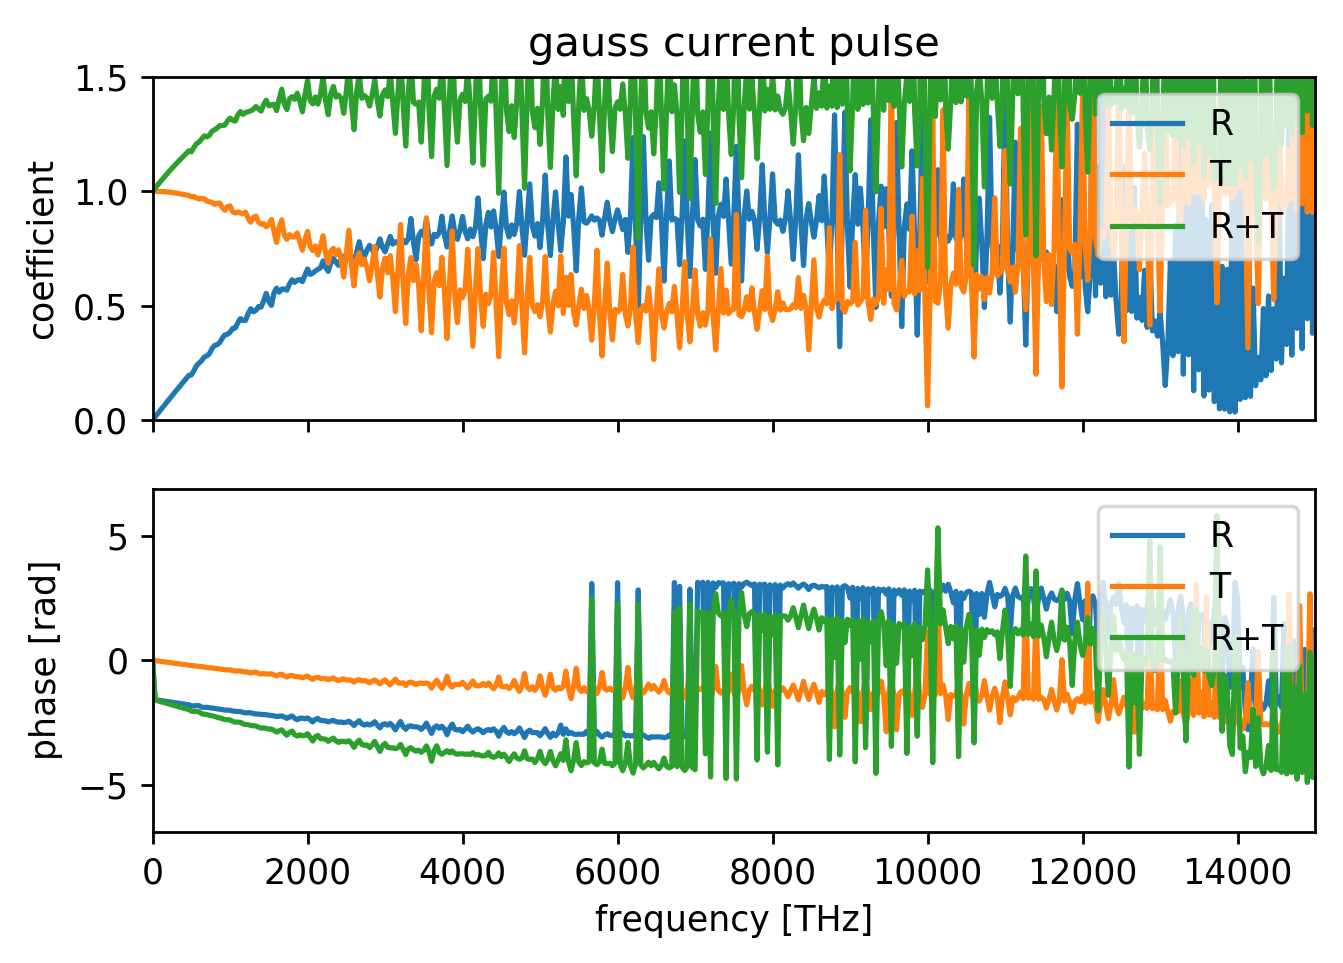

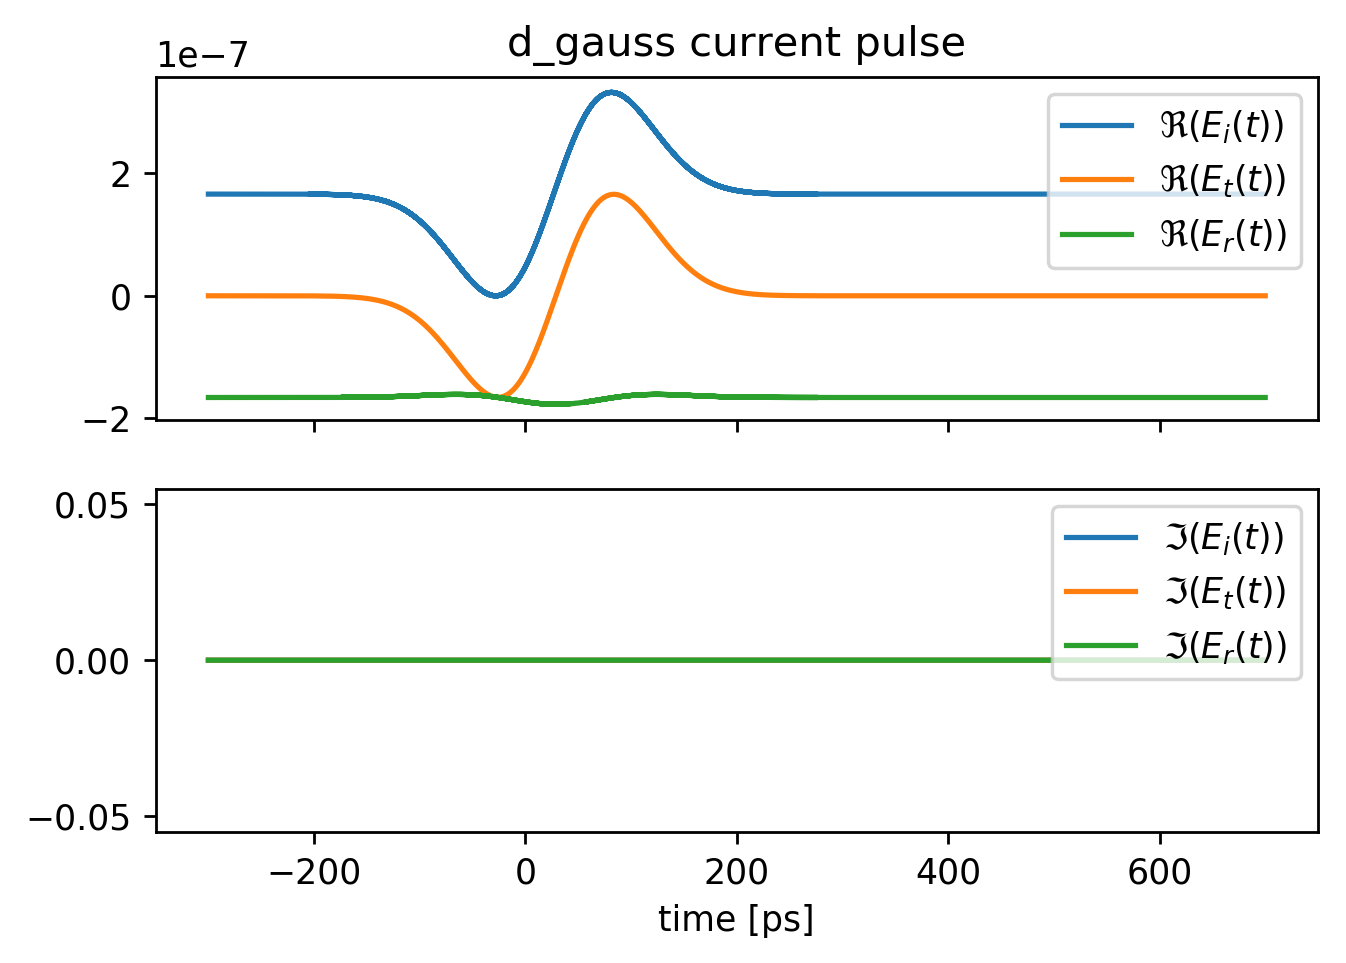

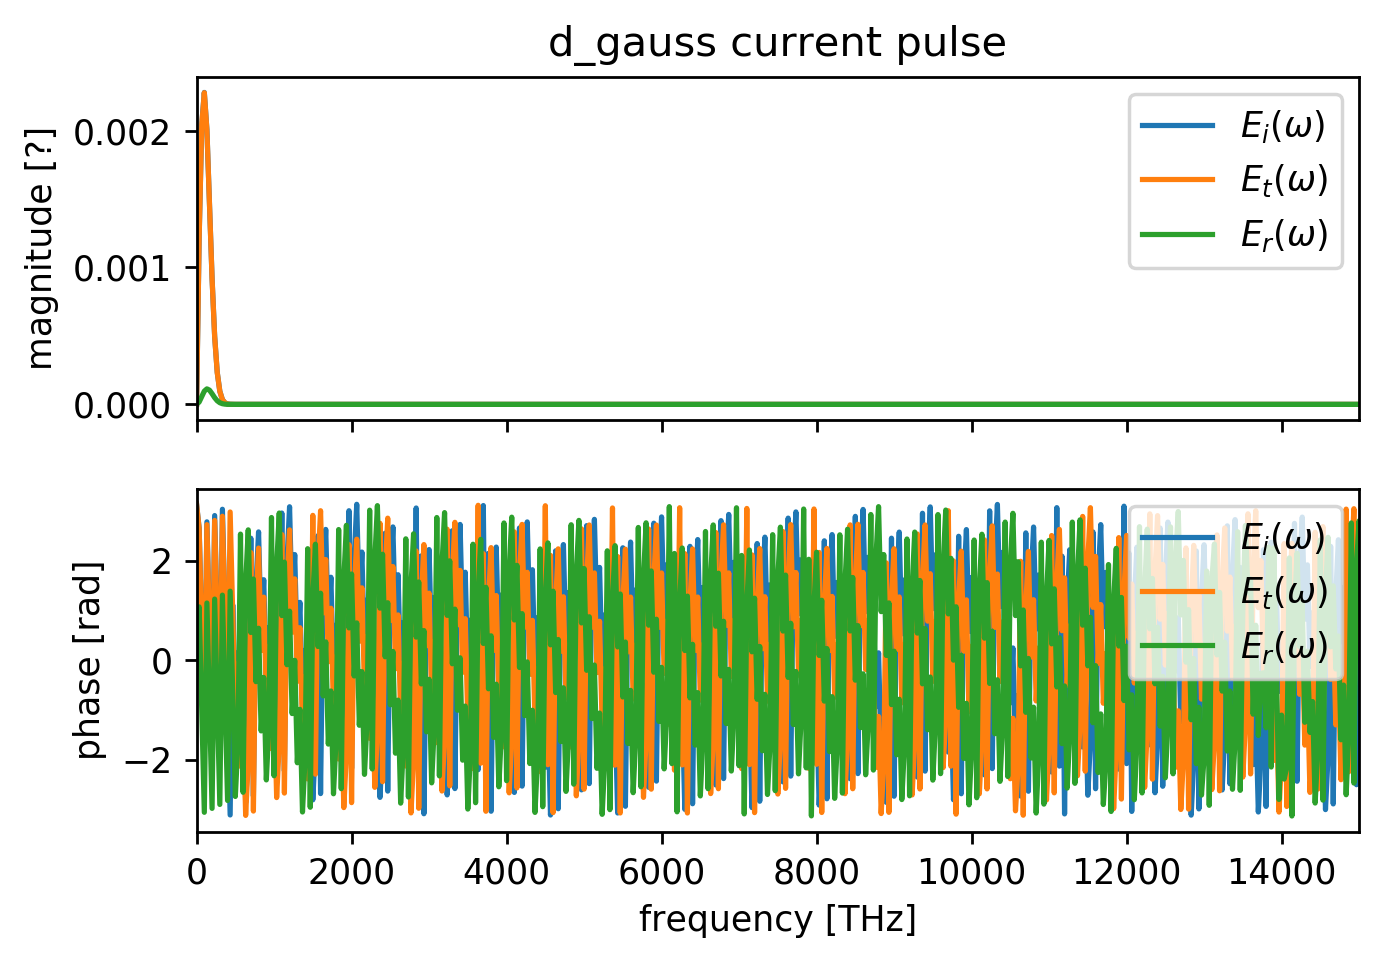

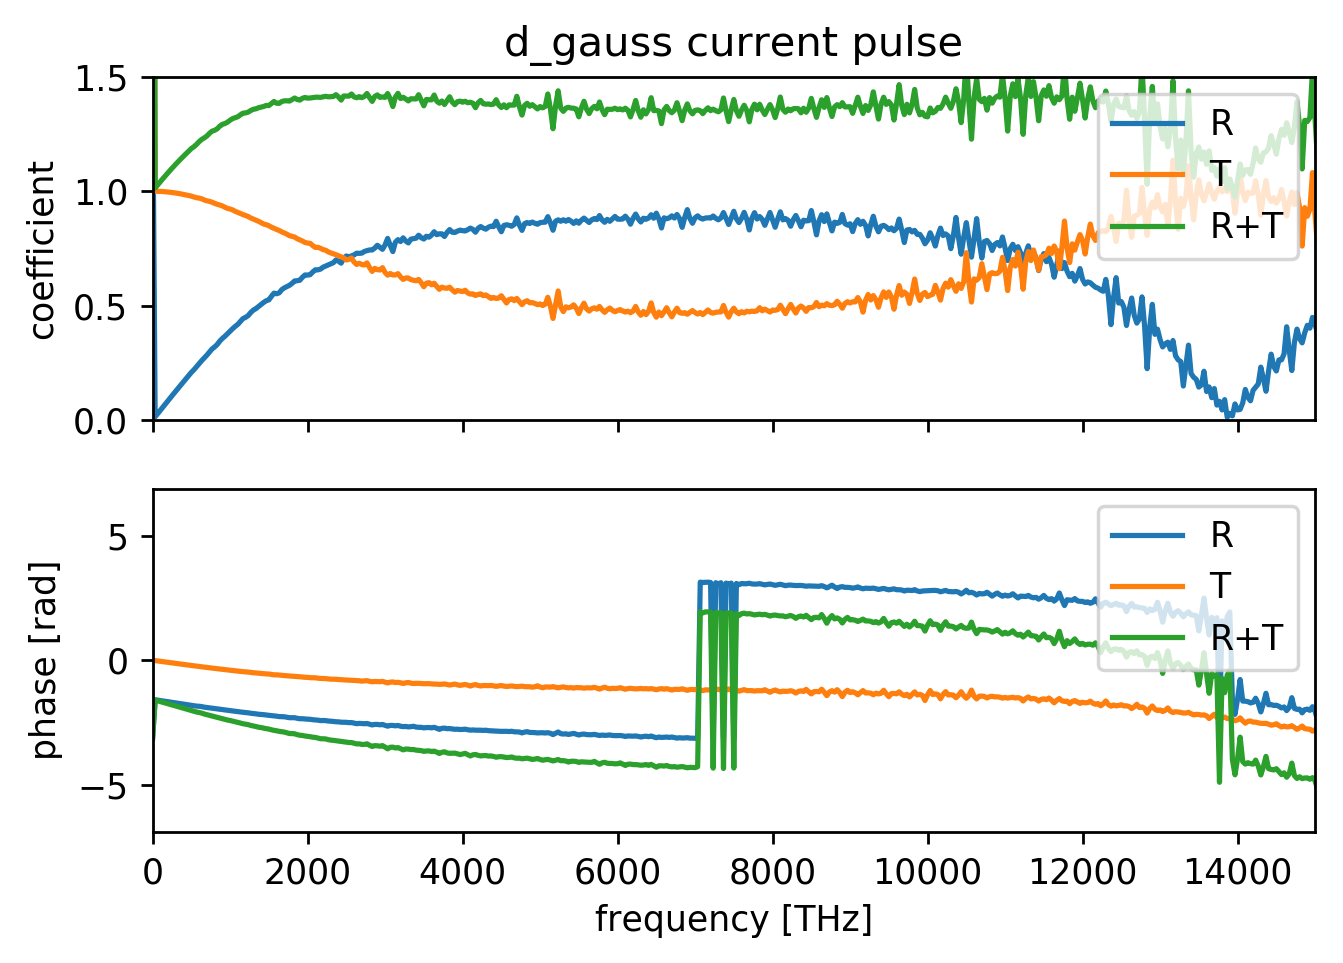

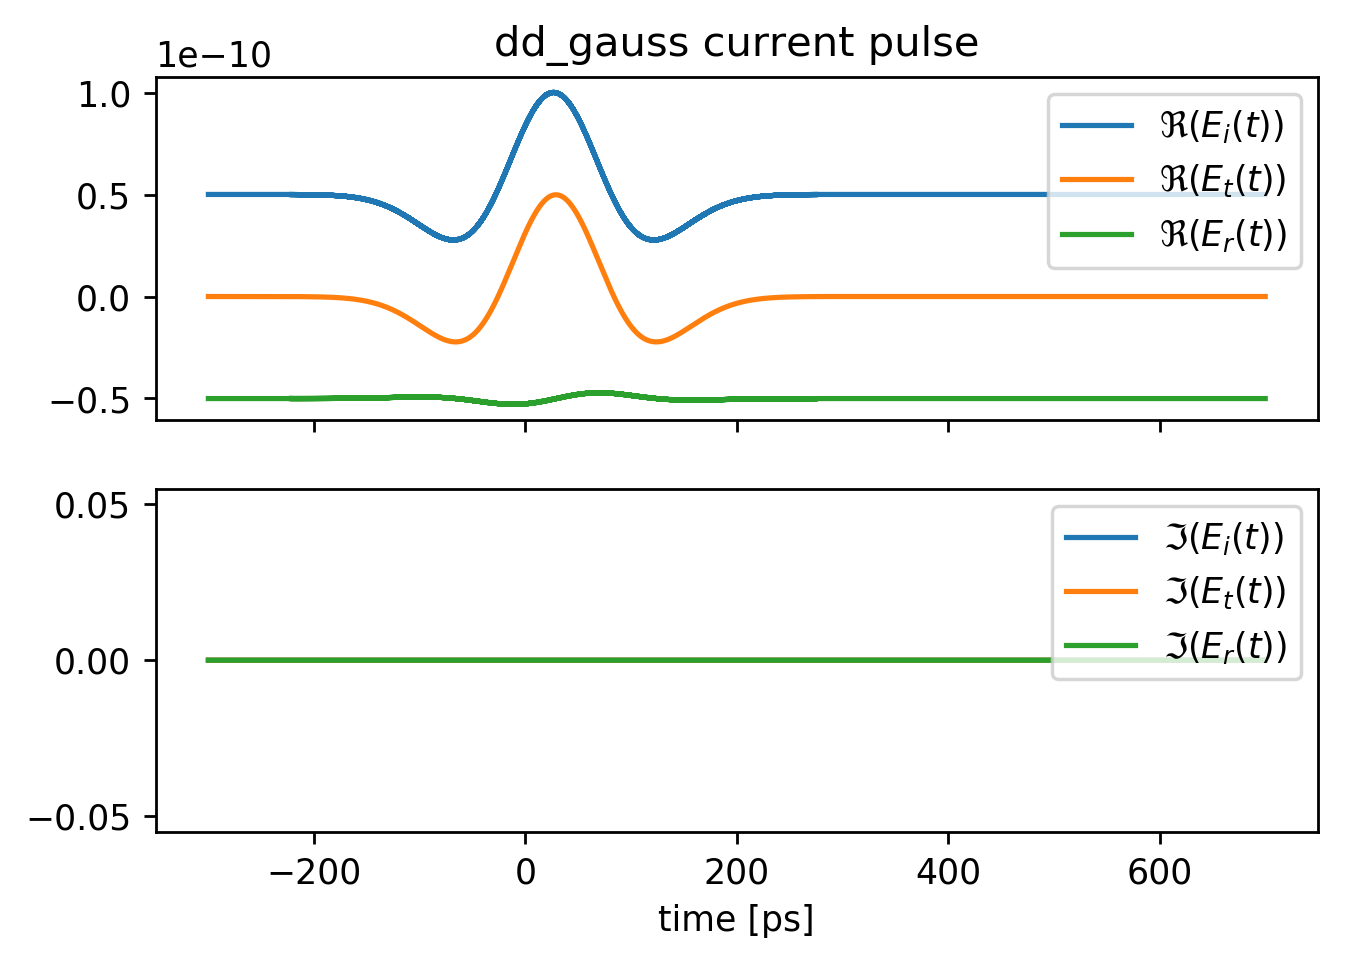

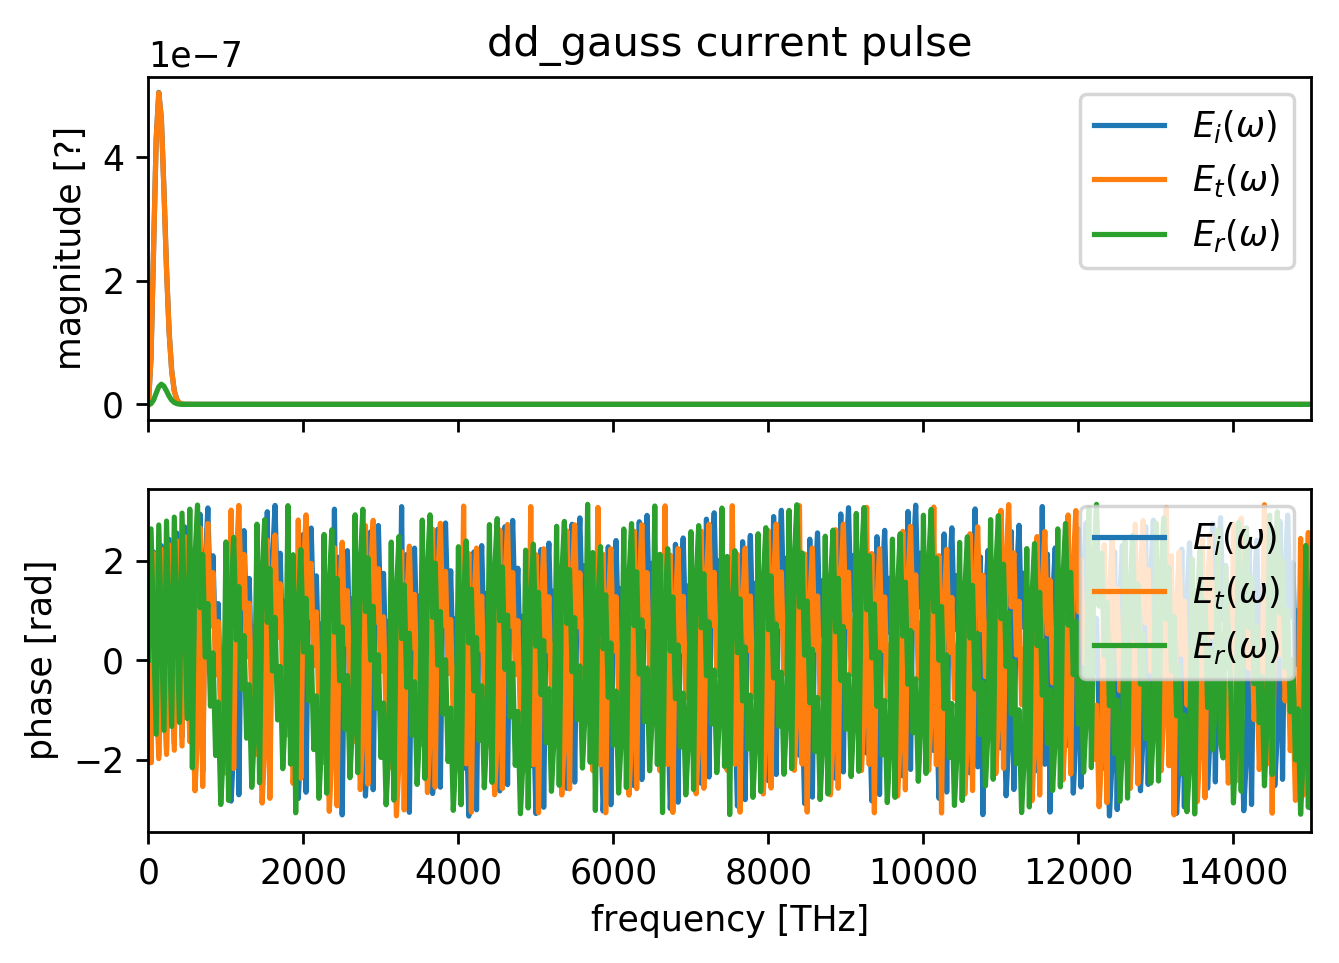

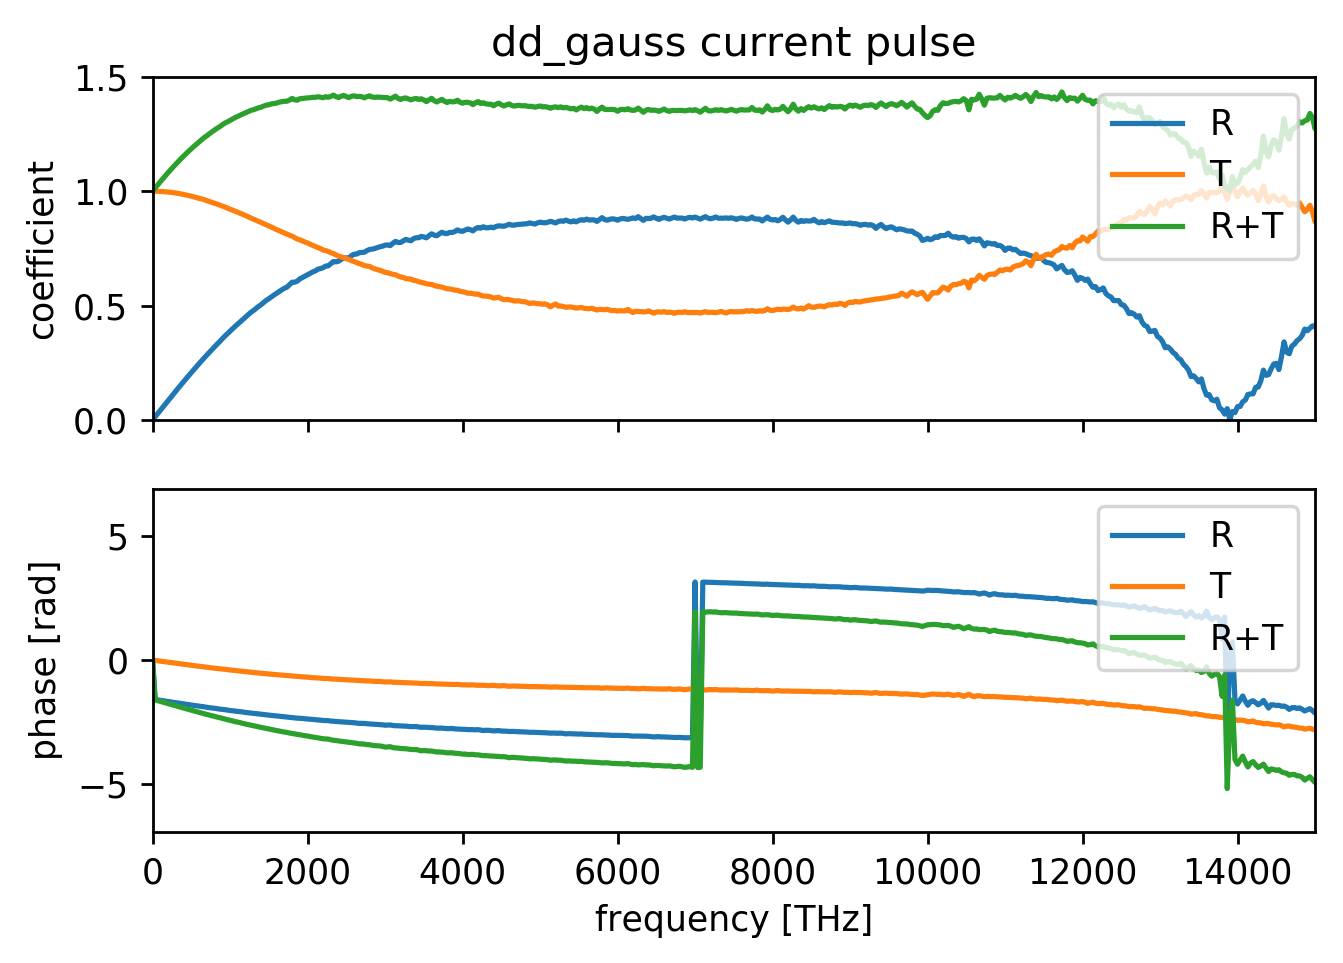

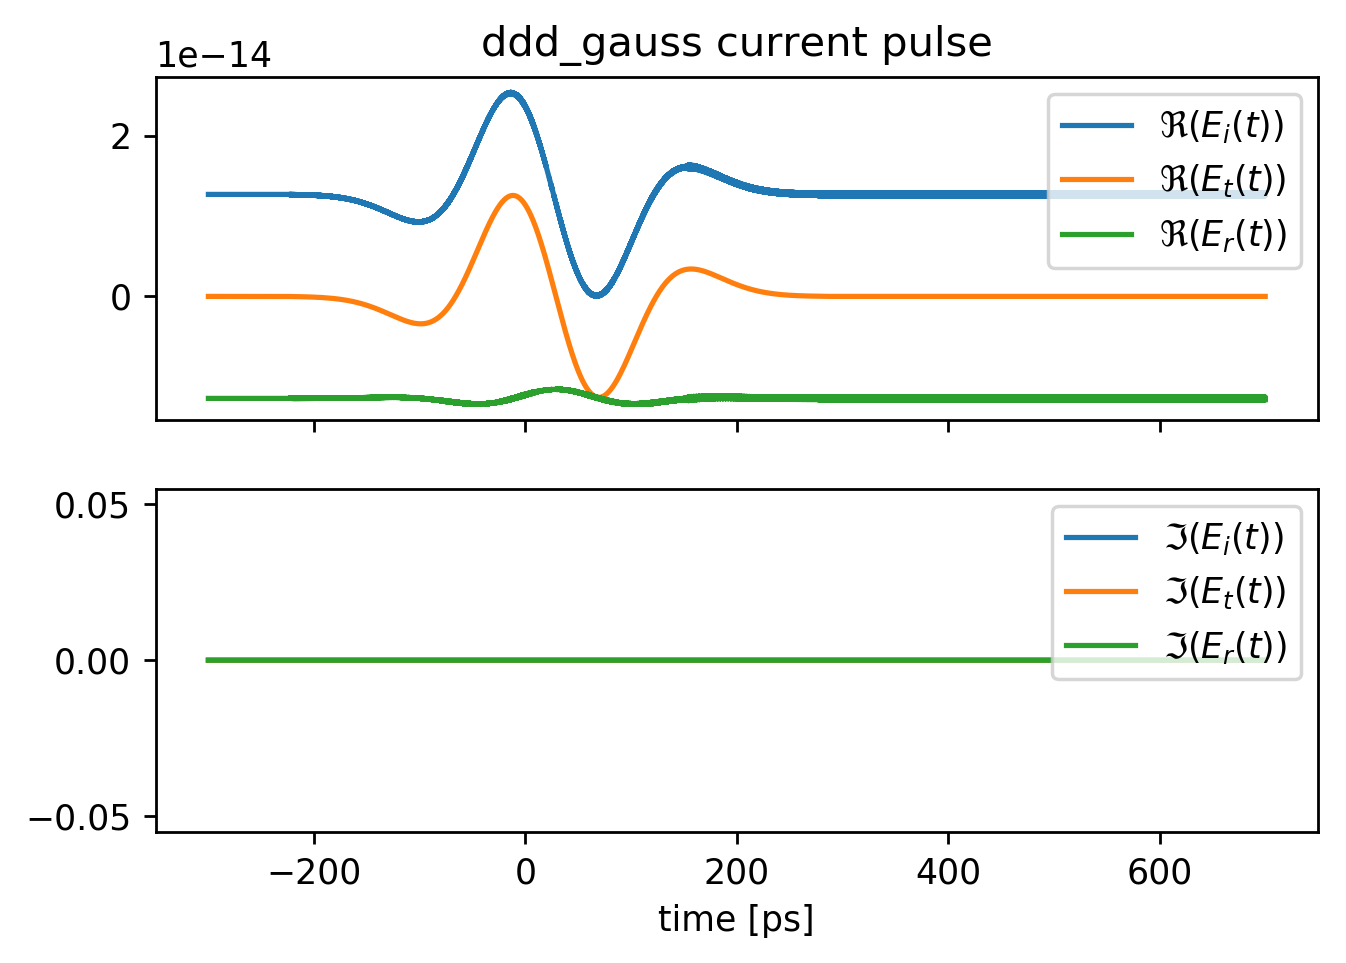

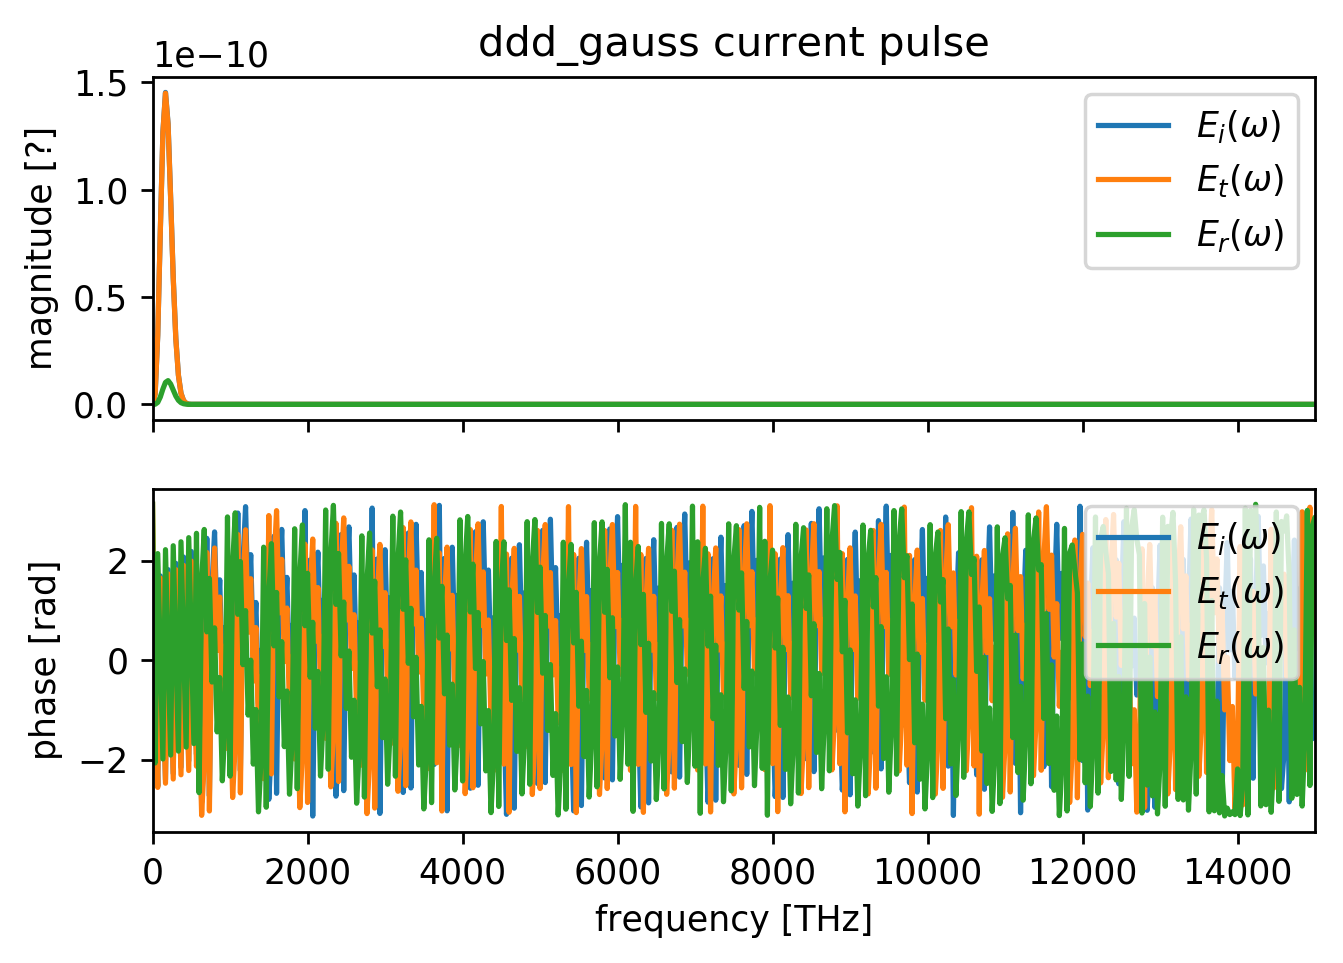

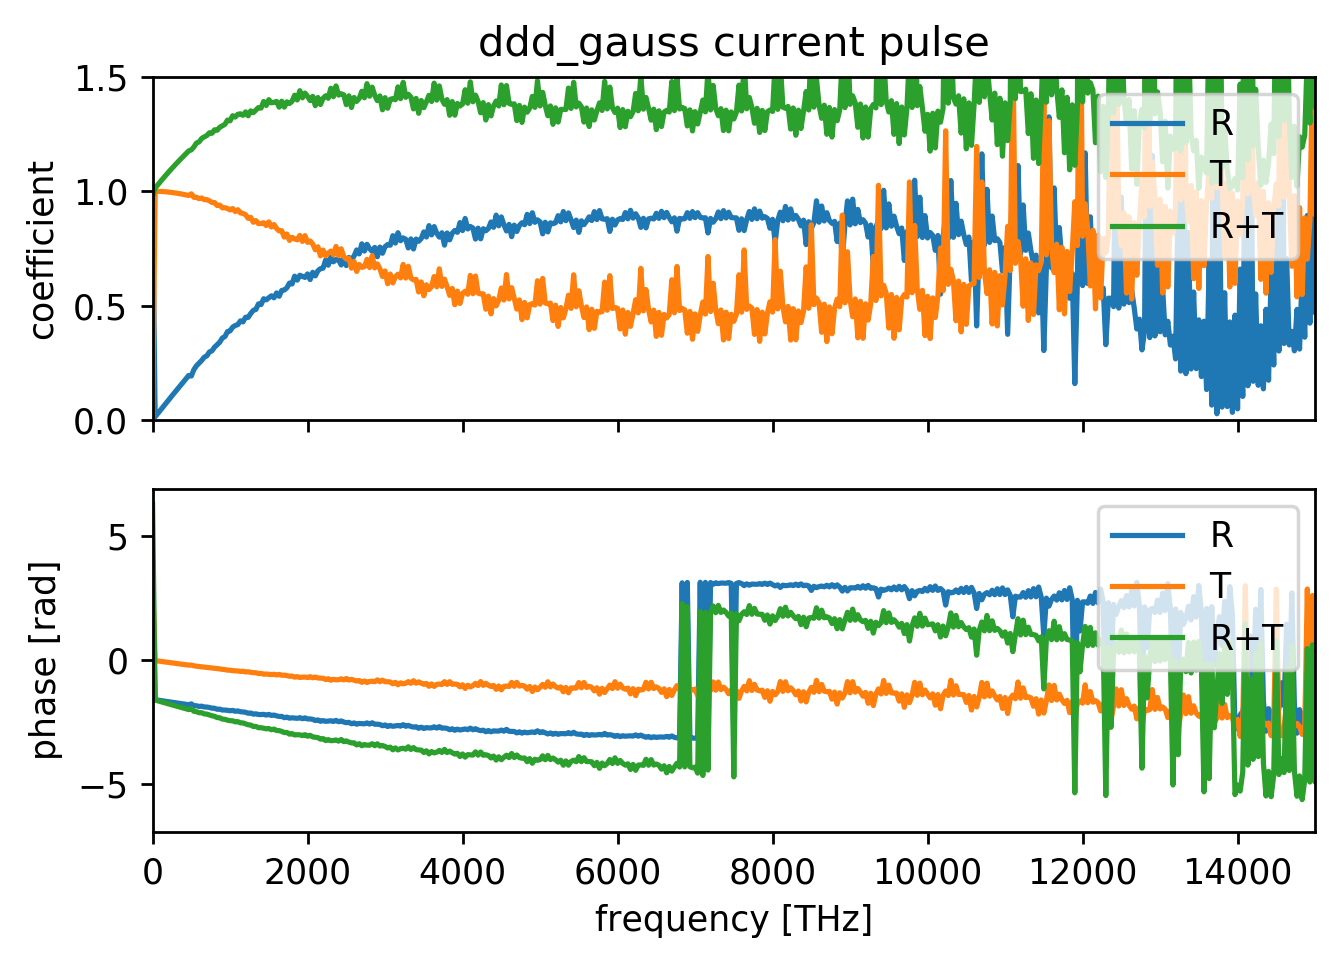

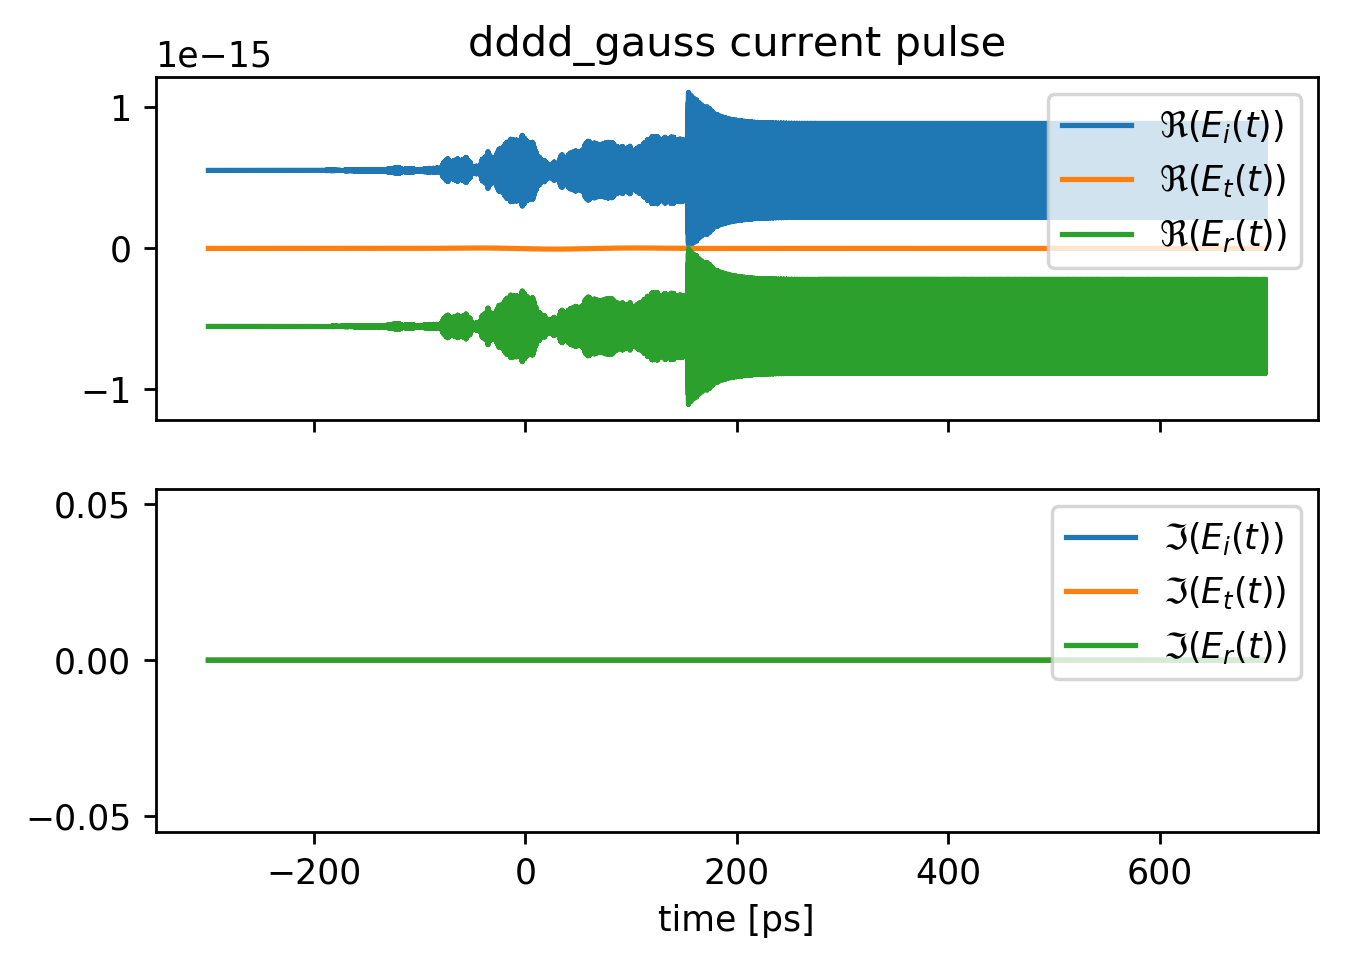

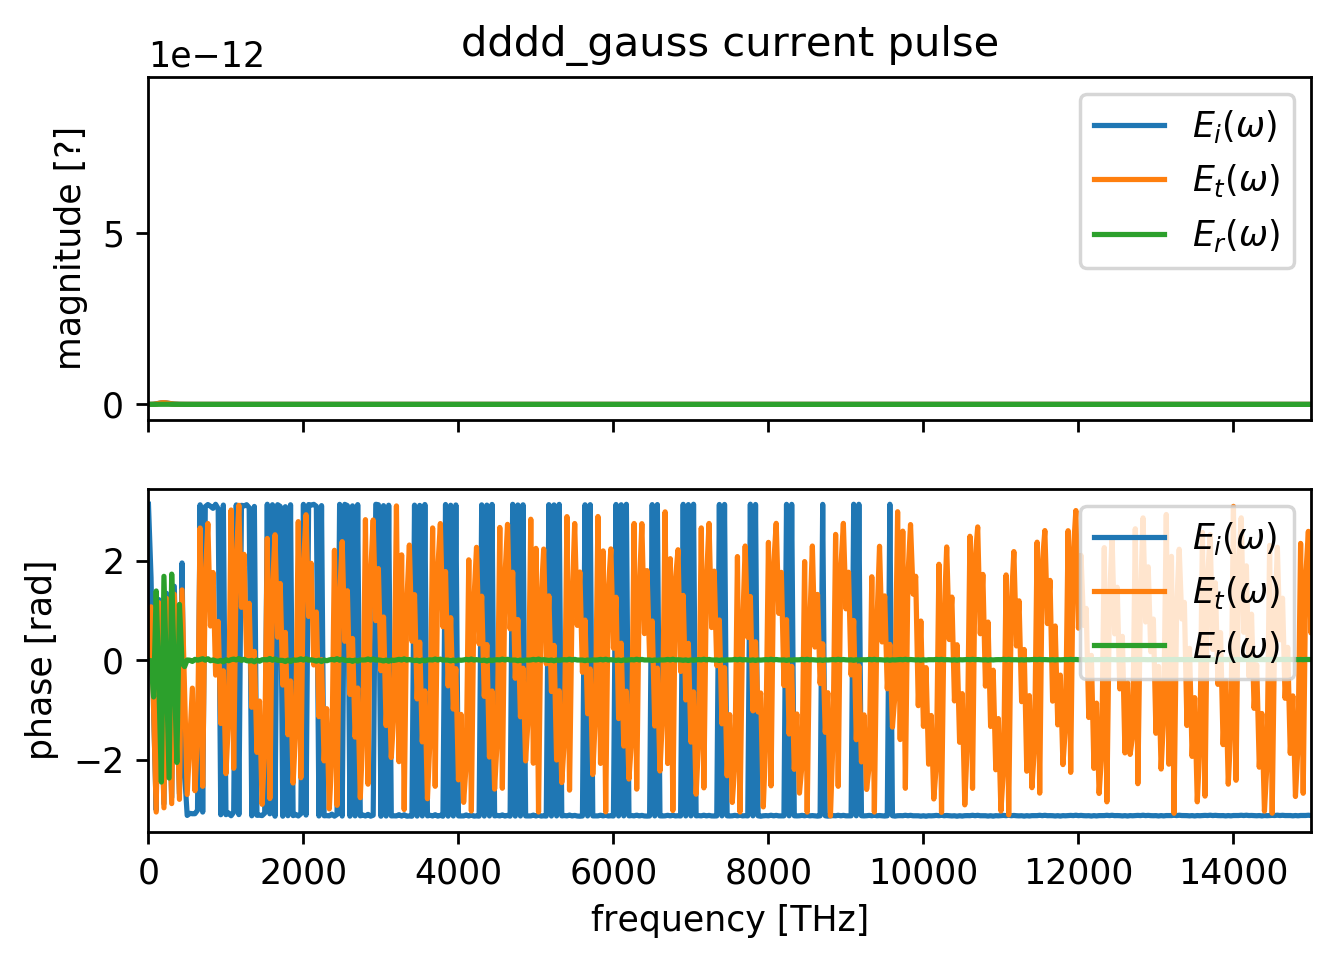

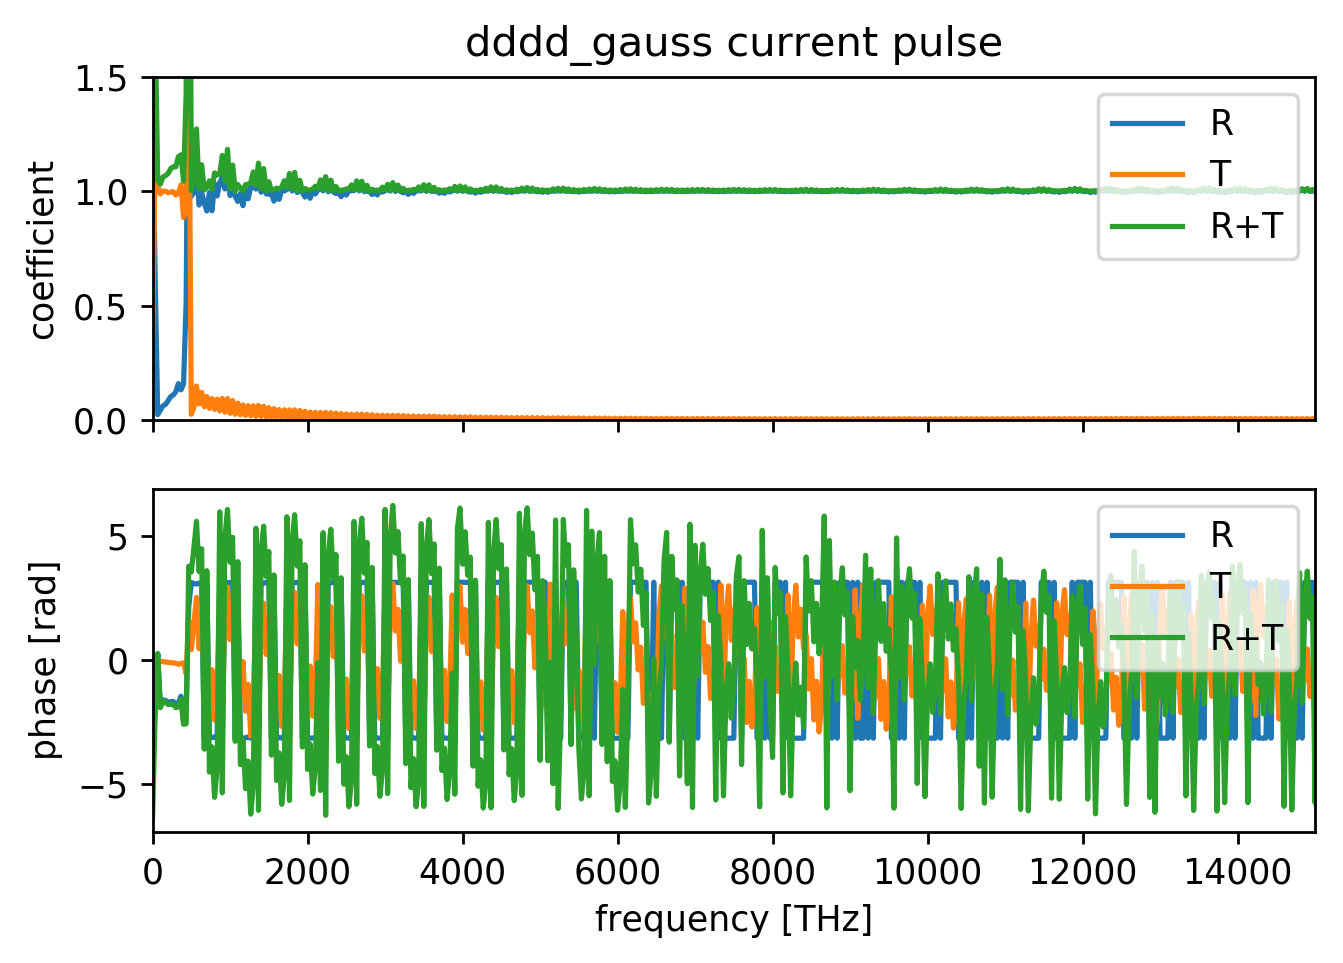

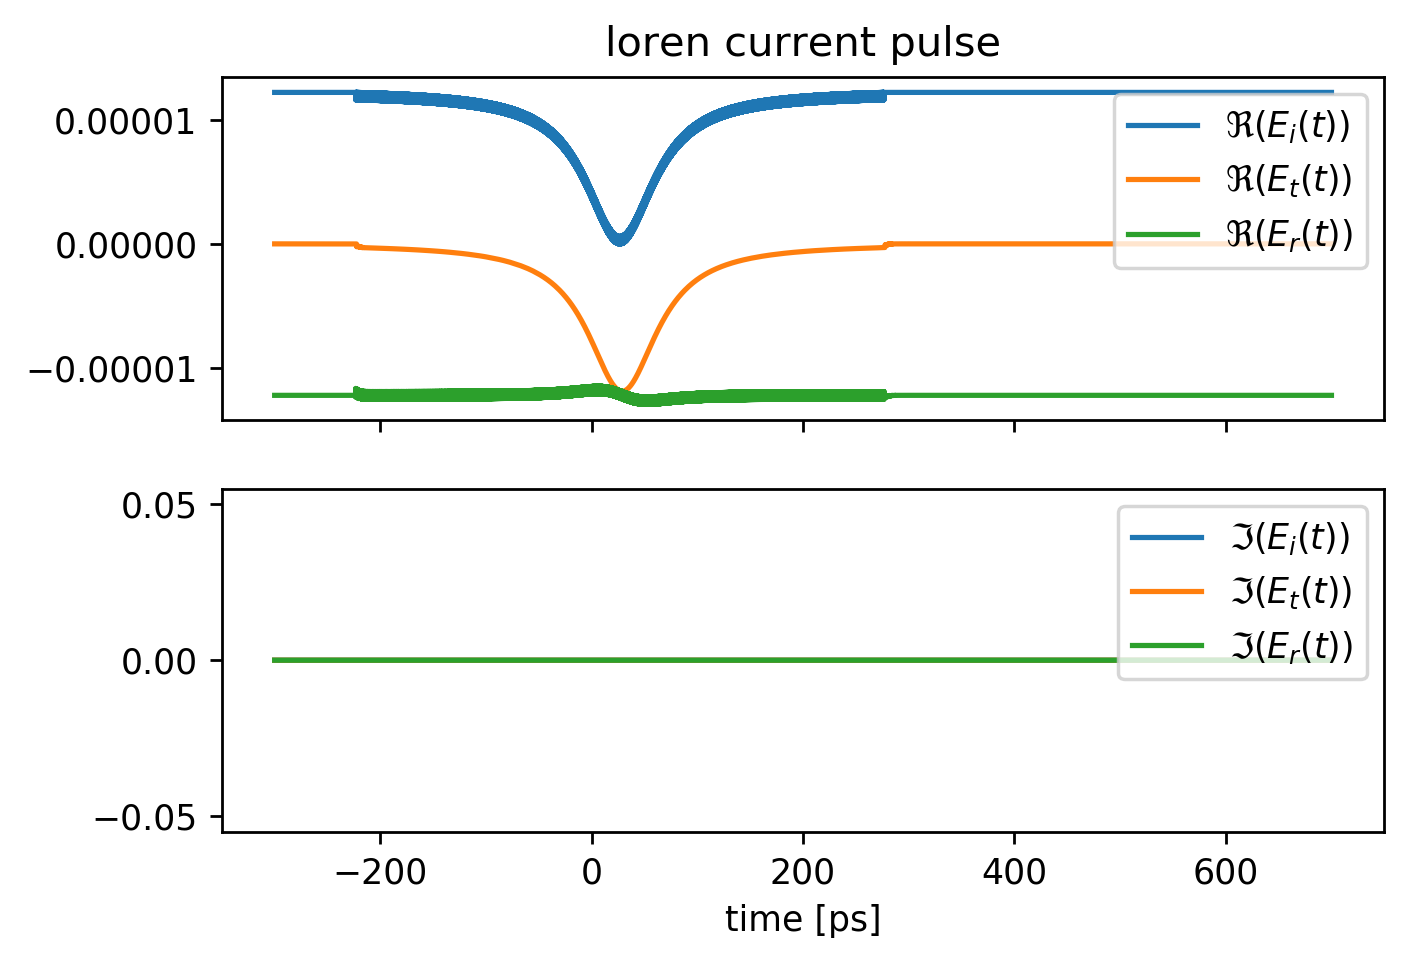

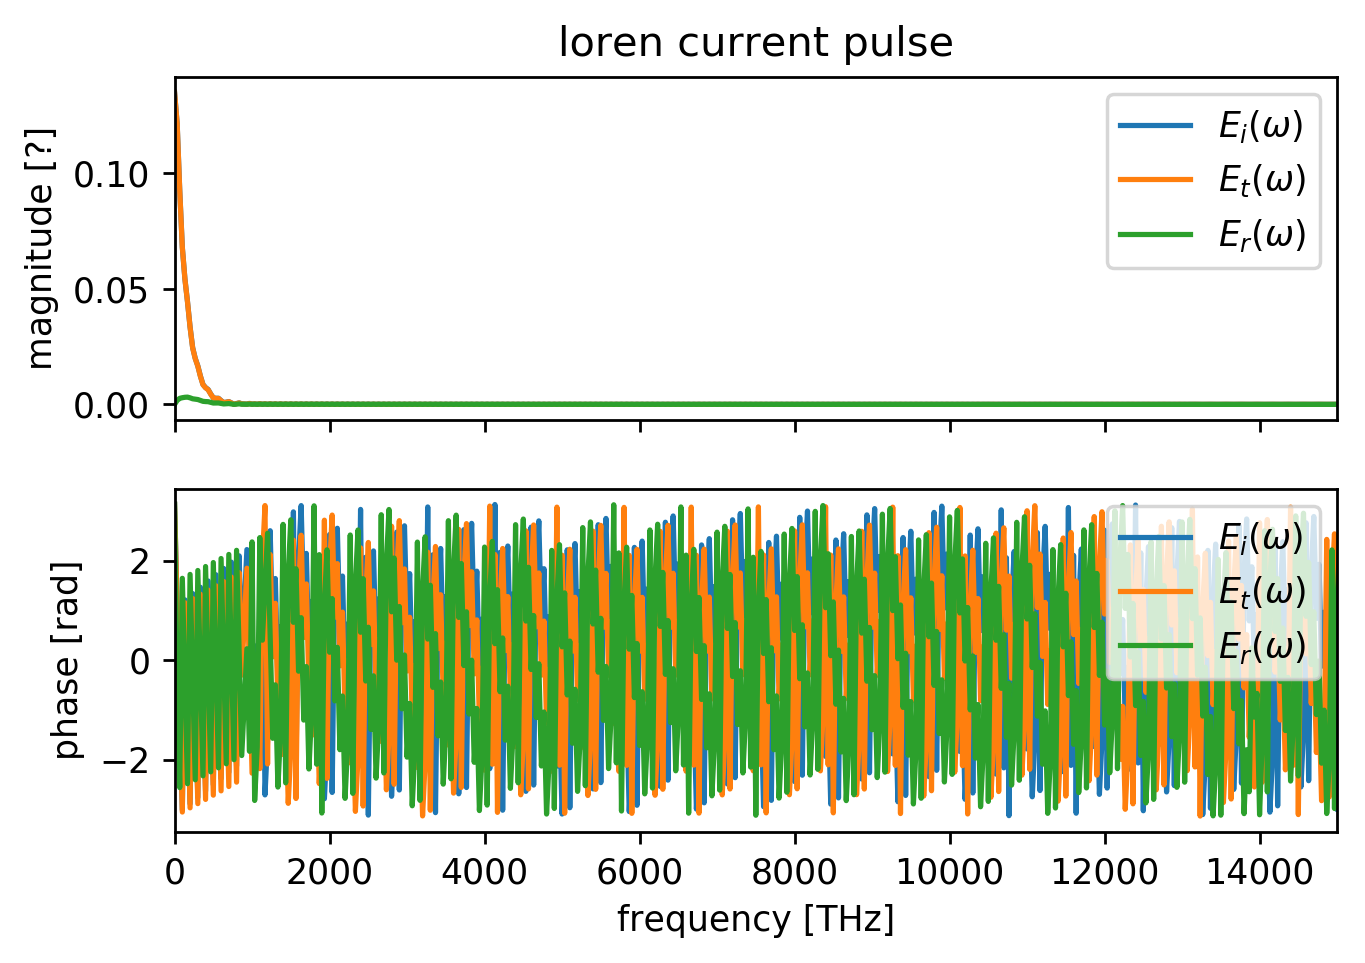

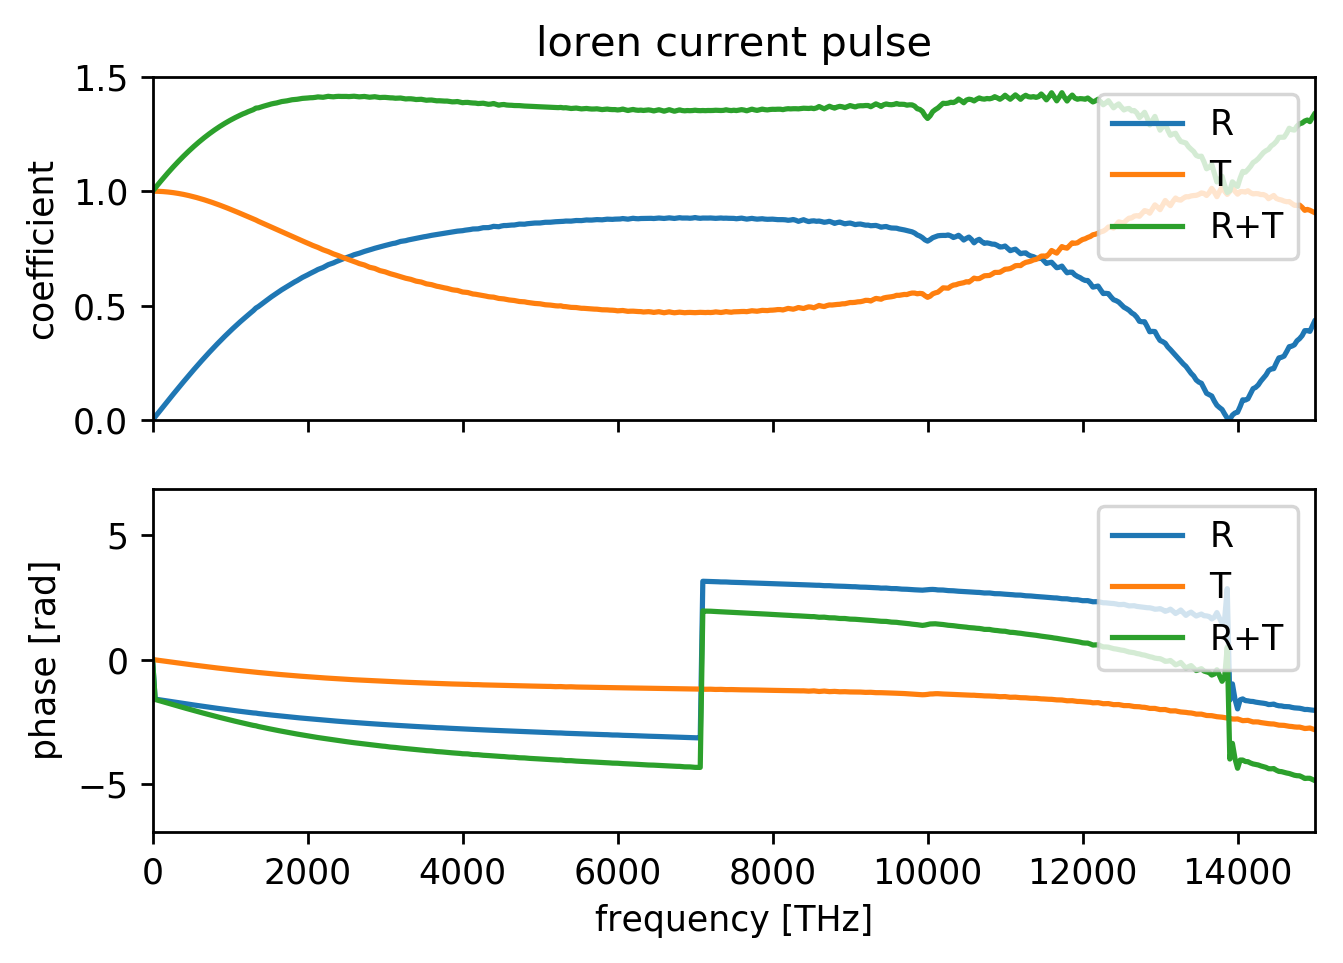

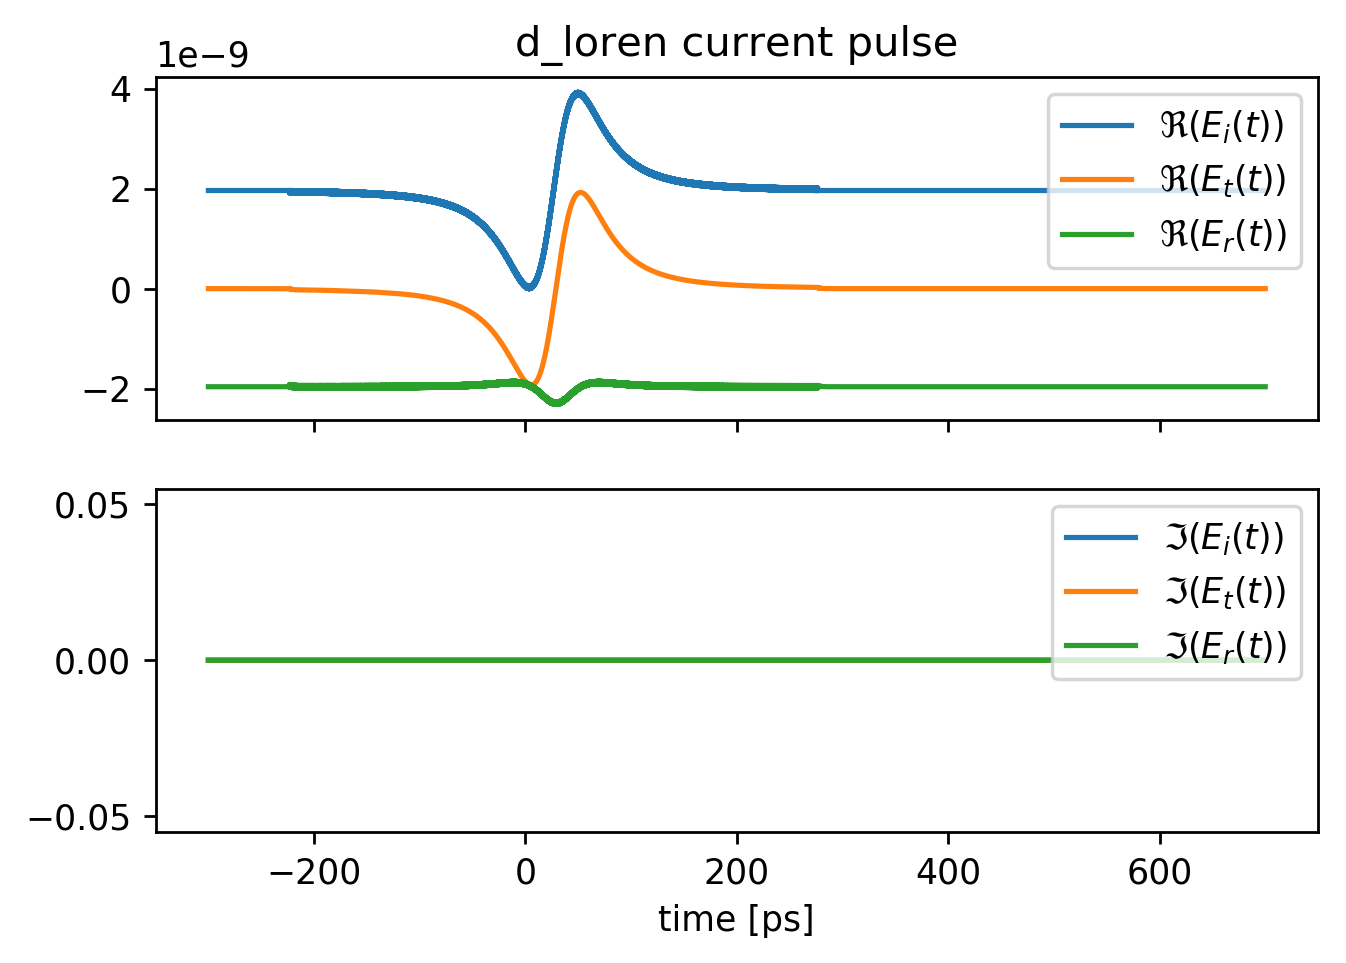

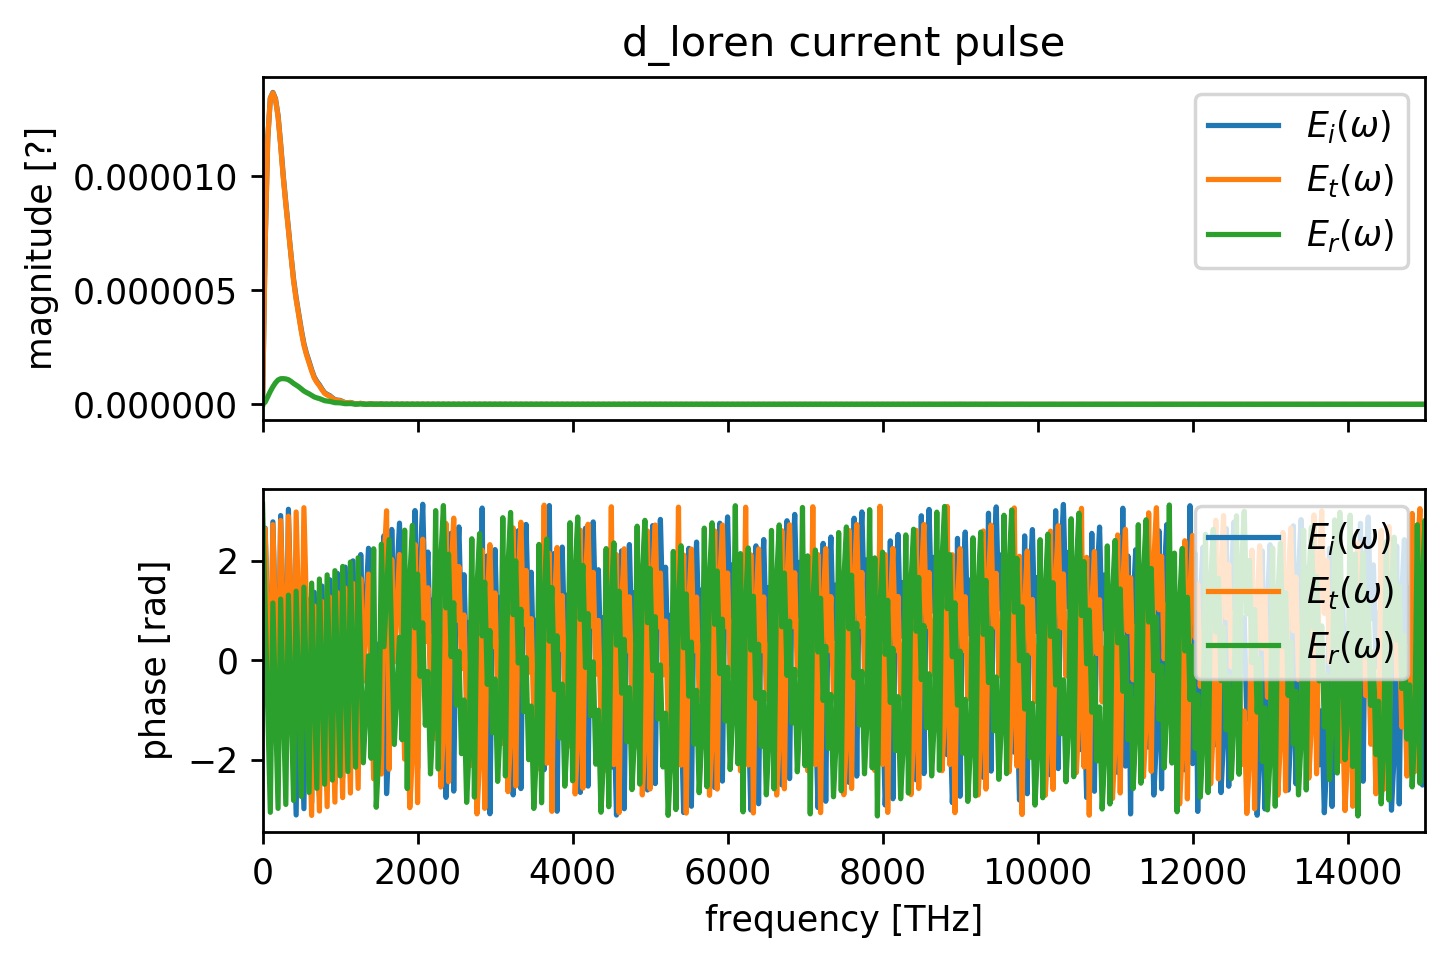

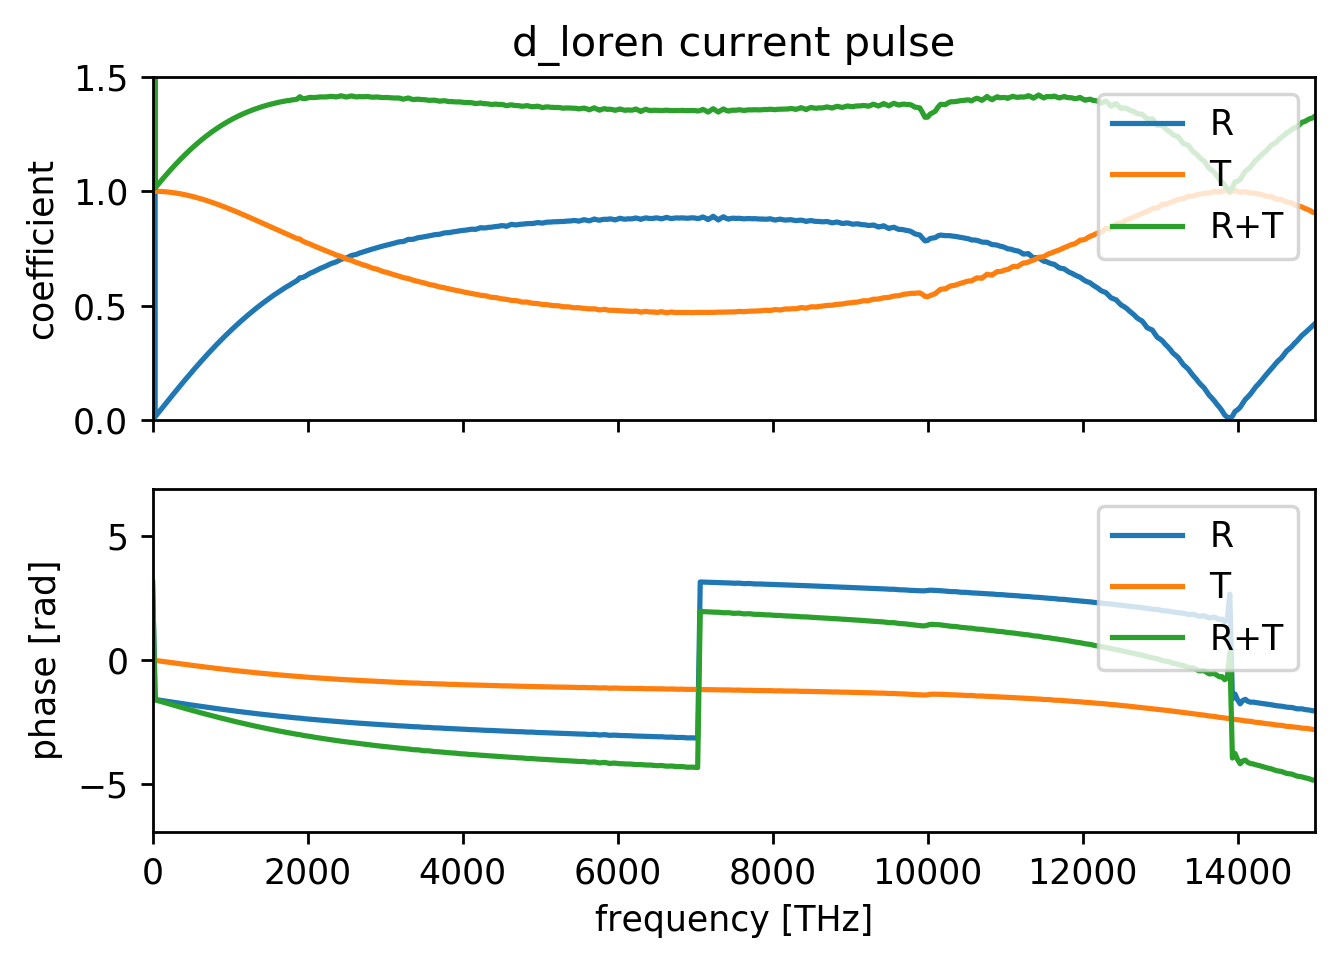

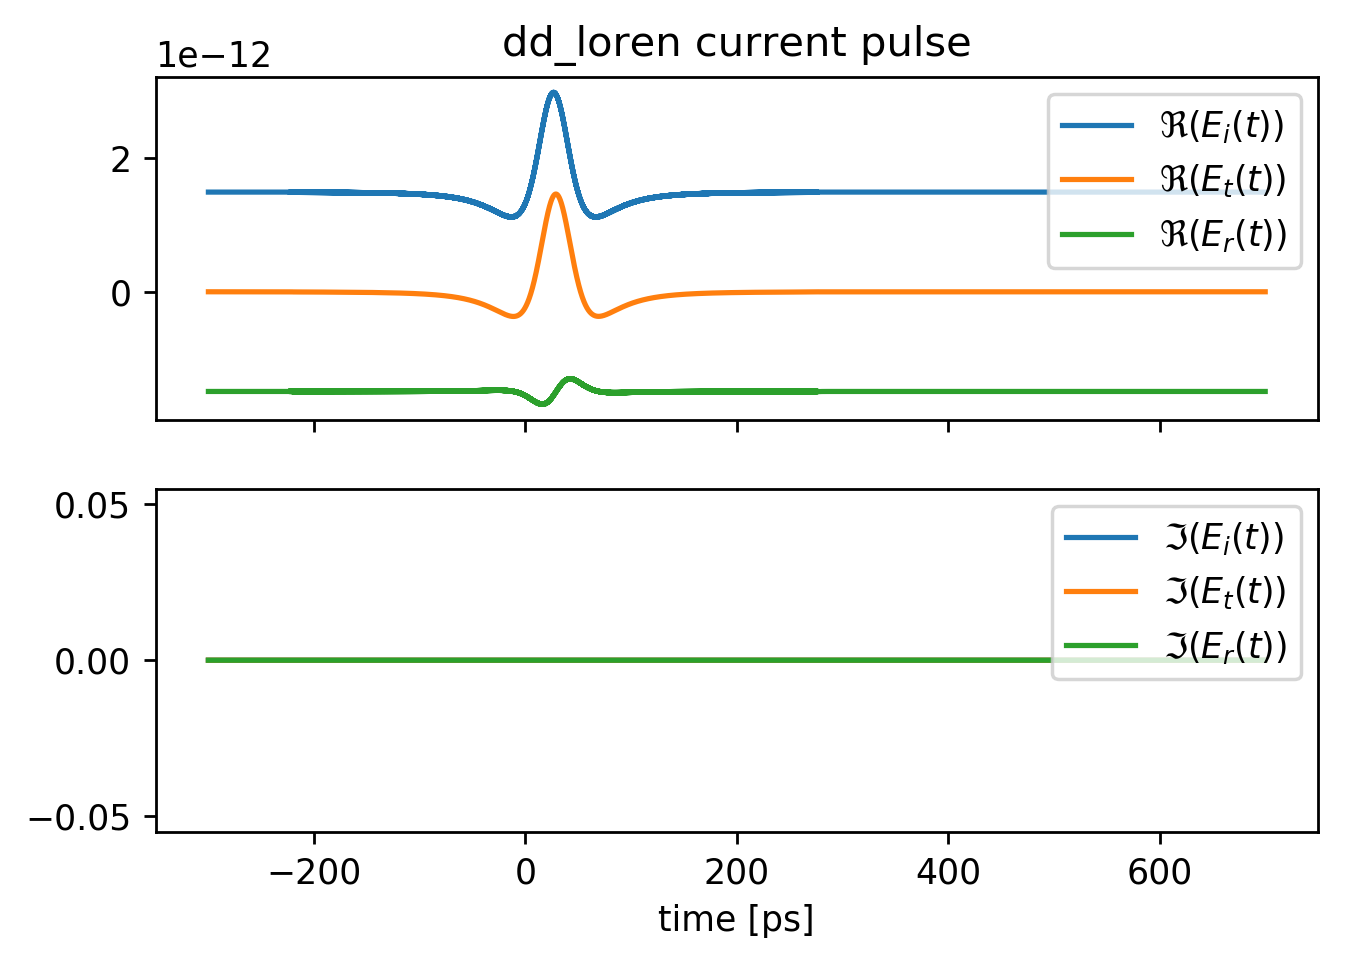

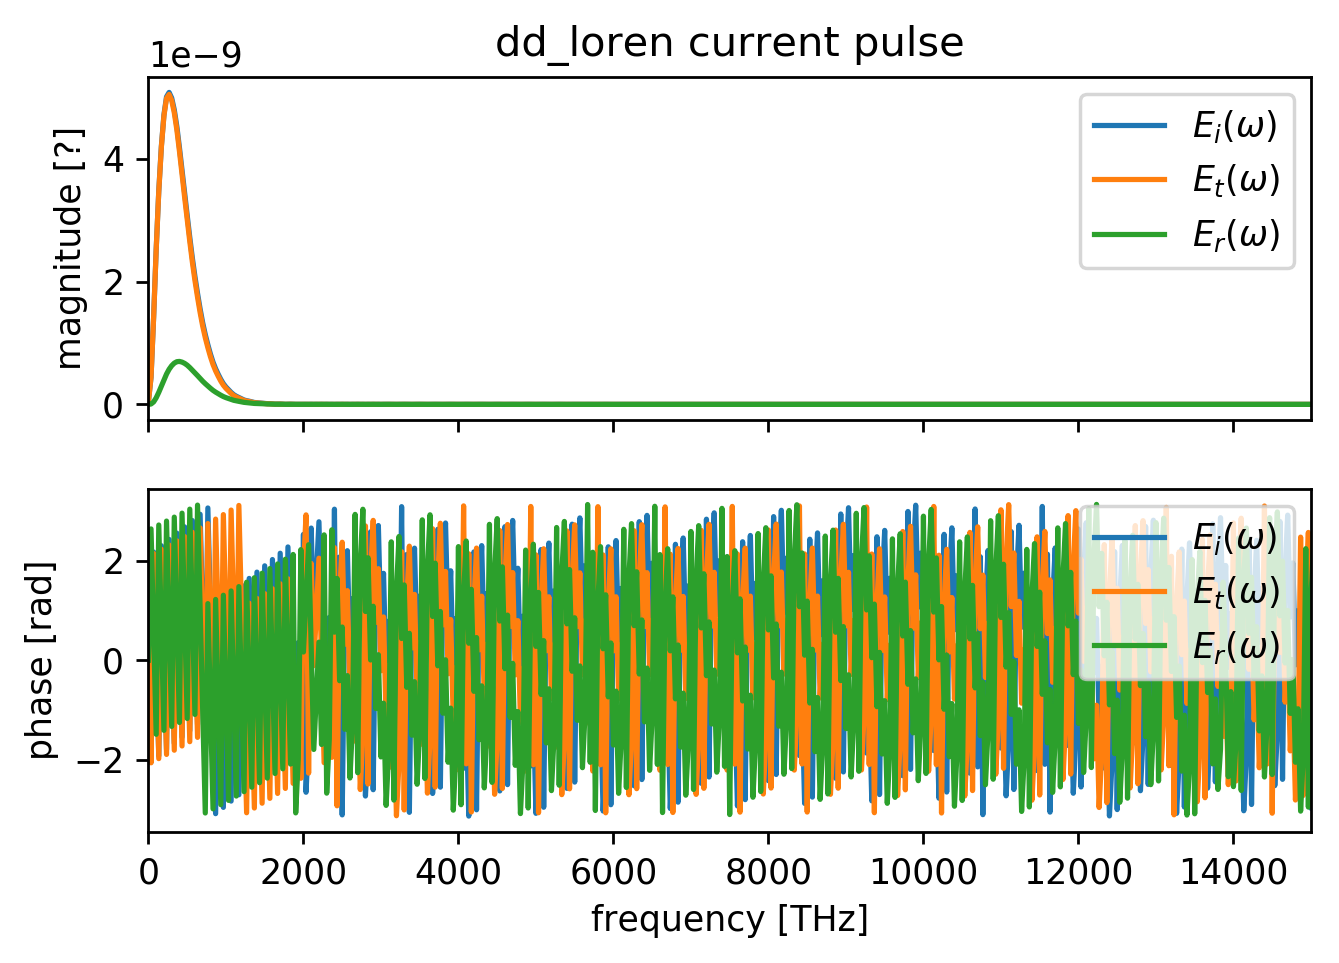

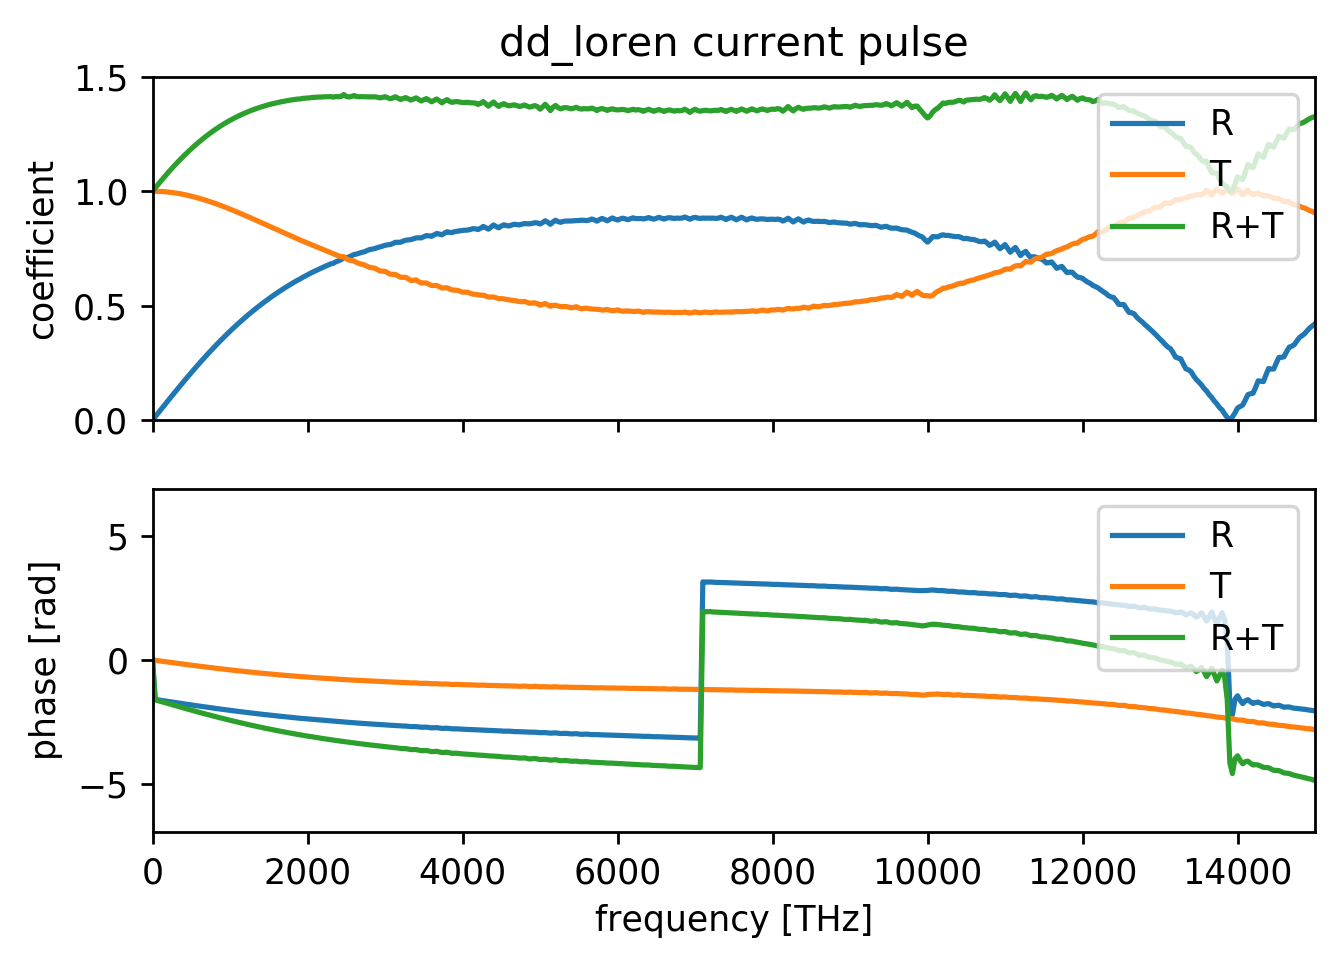

In [25]:
for i in range(len(cpulse_list)):
    # Extract current name
    name = cpulse_list_names[i]
    sfname = name + '.npz'
    sim_file = Path(sfname)
    # Only proceed if simulation files exist
    if sim_file.is_file():
        # Load results
        # ------------
        dat = np.load(sfname)
        n = dat['n']
        ls = dat['ls']
        els = dat['els']
        erls = dat['erls']
        hls = dat['hls']
        hrls = dat['hrls']
        chi = dat['chi']
        # Plot fields in time
        # -------------------
        # Extract fields in time
        inc, trans, refl = calc_fields(els, erls)
        # Calculate offsets
        rofst = np.max(np.abs(np.real([inc, trans, refl])))
        iofst = np.max(np.abs(np.imag([inc, trans, refl])))
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(n, np.real(inc)+rofst, label='$\Re(E_i(t))$')
        ax0.plot(n, np.real(trans), label='$\Re(E_t(t))$')
        ax0.plot(n, np.real(refl)-rofst, label='$\Re(E_r(t))$')
        ax1.plot(n, np.imag(inc)+iofst, label='$\Im(E_i(t))$')
        ax1.plot(n, np.imag(trans), label='$\Im(E_t(t))$')
        ax1.plot(n, np.imag(refl)-iofst, label='$\Im(E_r(t))$')
        ax0.set_title(name + ' current pulse')
        ax0.legend(loc=1)
        ax1.legend(loc=1)
        ax1.set_xlabel('time [ps]')
        plt.gcf().set_dpi(250)
        plt.show()
        # Plot FFT results
        # ----------------
        # Calculate FFT
        nf, incf, transf, reflf = calc_transforms(nlen, dn, inc, trans, refl)
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(nf, np.absolute(incf), label='$E_i(\omega)$')
        ax0.plot(nf, np.absolute(transf), label='$E_t(\omega)$')
        ax0.plot(nf, np.absolute(reflf), label='$E_r(\omega)$')
        ax0.legend(loc=1)
        ax0.set_title(name + ' current pulse')
        ax0.set_ylabel('magnitude [?]')
        ax1.plot(nf, np.angle(incf), label='$E_i(\omega)$')
        ax1.plot(nf, np.angle(transf), label='$E_t(\omega)$')
        ax1.plot(nf, np.angle(reflf), label='$E_r(\omega)$')
        ax1.legend(loc=1)
        ax1.set_ylabel('phase [rad]')
        plt.xlabel('frequency [THz]')
        plt.xlim(0, 1.5e4)
        plt.gcf().set_dpi(250)
        plt.show()
        # Plot Coefficients
        # -----------------
        # Coefficient Plot
        R = np.divide(reflf, incf)
        T = np.divide(transf, incf)
        # Plot
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        ax0.plot(nf, np.absolute(R), label='R')
        ax0.plot(nf, np.absolute(T), label='T')
        ax0.plot(nf, np.absolute(R)+np.absolute(T), label='R+T')
        ax0.legend(loc=1)
        ax0.set_title(name + ' current pulse')
        ax0.set_ylabel('coefficient')
        ax0.set_ylim(0, 1.5)
        ax1.plot(nf, np.angle(R), label='R')
        ax1.plot(nf, np.angle(T), label='T')
        ax1.plot(nf, np.angle(R)+np.angle(T), label='R+T')
        ax1.legend(loc=1)
        ax1.set_ylabel('phase [rad]')
        ax1.set_xlabel('frequency [THz]')
        plt.xlim(0, 1.5e4)
        plt.gcf().set_dpi(250)
        plt.show()